In [1]:
import torch
import matplotlib.pyplot as plt
import torch.distributions as dist
# Matplotlib retina
%config InlineBackend.figure_format = 'retina'

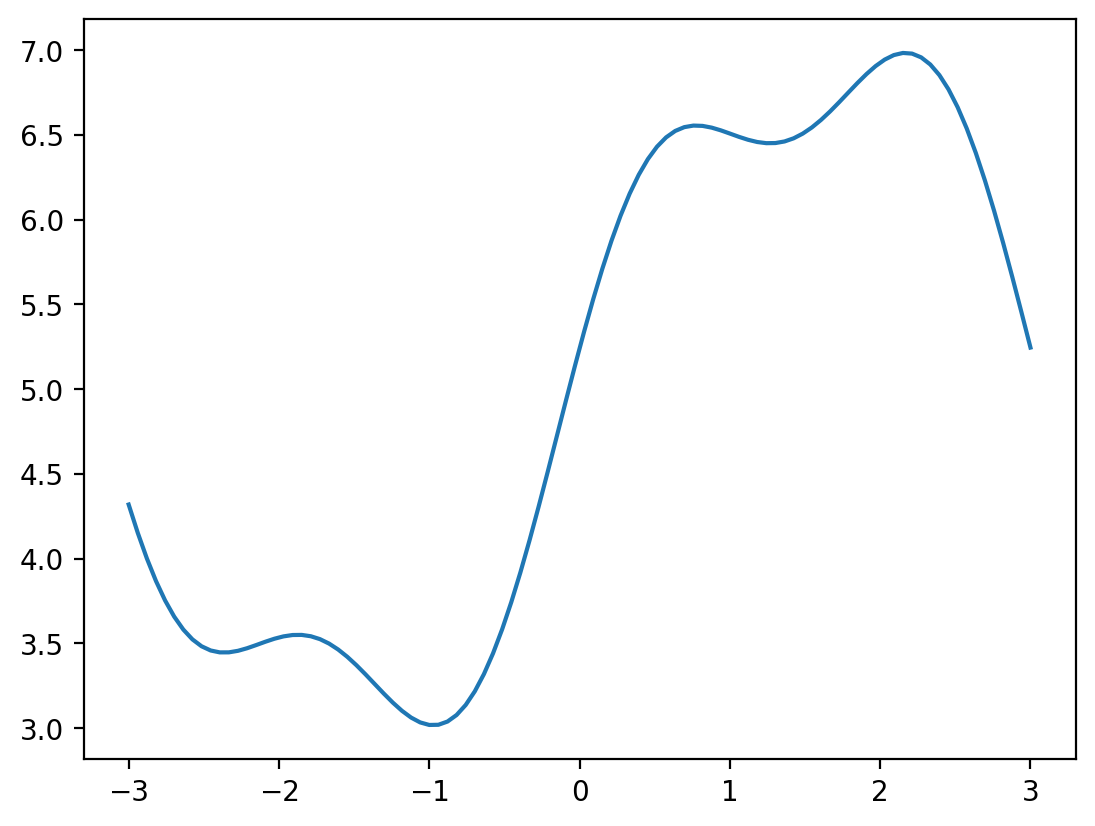

In [2]:
x_lin  = torch.linspace(-3, 3, 100).reshape(-1, 1)
#f = lambda x: 2*torch.sin(x) + torch.sin(2*x**(1.1) + 1) + 0.3*x + 10
f = lambda x: 2*torch.sin(x) + 0.5*torch.sin(3*x + 0.5) + 5

plt.plot(x_lin, f(x_lin), label='f(x)')

In [3]:
def phi(x, degree=2):
    # sin features
    # [1, x, sin(x), sin(2x), ..., sin(degree*x)]
    # if degree=1, then [1, x]
    # if degree=2, then [1, x, sin(x)]
    # if degree=3, then [1, x, sin(x), sin(2x)]
    
    x_new = torch.cat([torch.ones_like(x), x], dim=1)
    for d in range(2, degree+1):
        x_new = torch.cat([x_new, torch.sin(d*x), torch.cos(d*x), torch.sin(d*x + .5), torch.cos(d*x + 0.5)], dim=1)
    return x_new

def num_params(degree):
    if degree == 1:
        return 2 #[1, x]
    else: 
        return 2 + 4*(degree-1)


In [4]:
class BLR:
    def __init__(self, mu, sigma, sigma_noise, degree=2):
        self.current_mean = mu
        self.current_sigma = sigma
        self.sigma_noise = sigma_noise  # Add sigma_noise as an instance variable
        self.is_prior_set = True
        self.N = 0
        self.X_total = None
        self.y_total = None
        self.degree = degree
    
    def __repr__(self):
        return f'BLR(mu={self.current_mean},\n sigma={self.current_sigma}, \nsigma_noise={self.sigma_noise})'

    def update(self, X, y):
        """
        X: (n_points, n_features)
        y: (n_points, 1)
        """
        
        if not self.is_prior_set:
            raise Exception('Prior not set')
        n_points = X.shape[0]
        X_orig = X
        X = phi(X, self.degree)
        self.current_sigma_inverse = torch.inverse(self.current_sigma)
        XTX = torch.matmul(X.T, X)
        SN_inverse = self.current_sigma_inverse + XTX / self.sigma_noise**2
        SN = torch.inverse(SN_inverse)

        self.current_mean = torch.matmul(SN, torch.matmul(self.current_sigma_inverse, self.current_mean) + torch.matmul(X.T, y).ravel() / self.sigma_noise**2)
        self.current_sigma = SN
        self.N += n_points
        if self.X_total is None:
            self.X_total = X_orig
            self.y_total = y
        else:
            self.X_total = torch.cat((self.X_total, X_orig), 0)
            self.y_total = torch.cat((self.y_total, y), 0)

    def predict(self, X):
        if not self.is_prior_set:
            raise Exception('Prior not set')
        
        X_orig = X
        X = phi(X, self.degree)
        
        # Calculate the predictive mean and variance
        predictive_mean = torch.matmul(X, self.current_mean)
        predictive_variance = self.sigma_noise**2 + torch.diag(torch.matmul(X @ self.current_sigma, X.T))
        
        return predictive_mean, predictive_variance

    def plot_predictive(self, X, ax = None):
    
        X_orig = X
        X = phi(X, self.degree)
        
        # Posterior distribution
        posterior_mean = torch.matmul(X, self.current_mean)
        posterior_variance = 1 / self.sigma_noise**2 + torch.diag(torch.matmul(X @ self.current_sigma, X.T))
        
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 6))
        ax.set_title("Posterior Distribution")
        ax.fill_between(X_orig.ravel().numpy(), (posterior_mean - 2 * posterior_variance).numpy(), (posterior_mean + 2 * posterior_variance).numpy(), color='r', alpha=0.2, label='Posterior')
        
        ax.plot(X_orig.ravel().numpy(), posterior_mean.numpy(), 'r-', label='Posterior Mean')
        
        if self.X_total is not None:
            ax.scatter(self.X_total.numpy(), self.y_total.numpy(), c='purple', marker='*', label='Observed Data', s=200)
        
        ax.legend()
        ax.set_xlim(X_orig.ravel().min(), X_orig.ravel().max())
        return ax



In [5]:
d = 3
phi_x = phi(x_lin, degree=d)

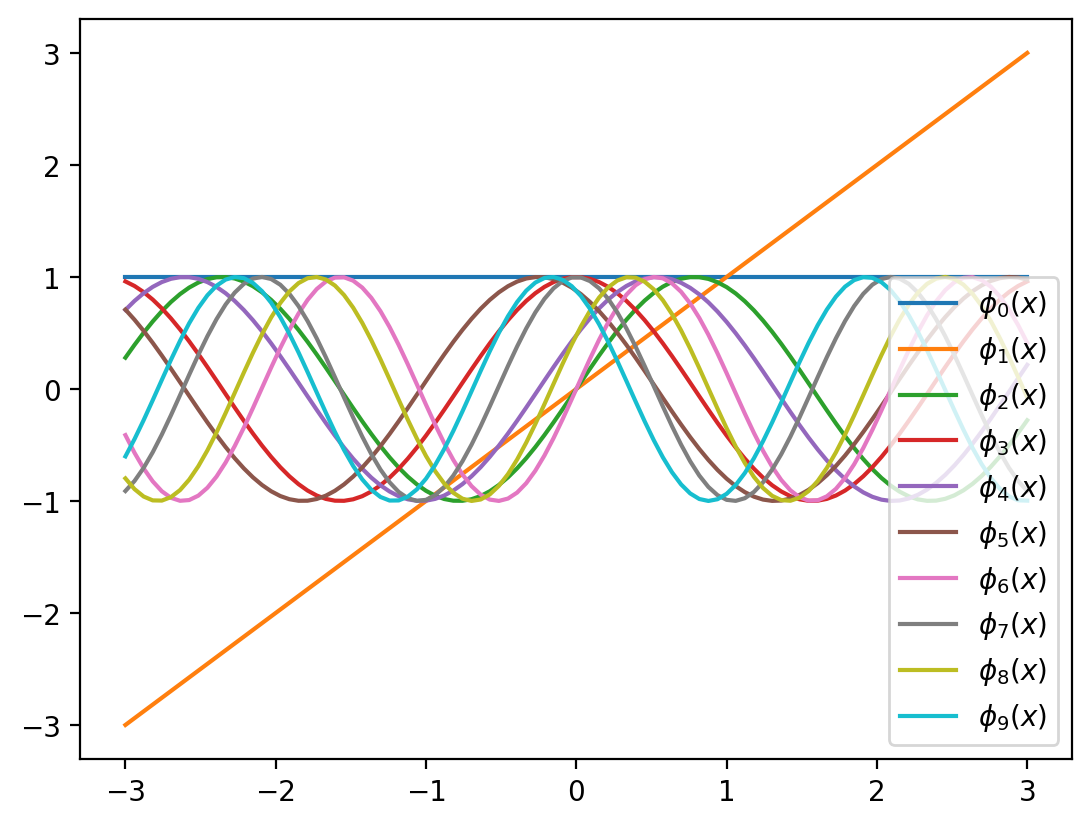

In [6]:
for i in range(num_params(d)):
    plt.plot(x_lin, phi_x[:, i], label=r'$\phi_{}(x)$'.format(i, i))
plt.legend()

In [7]:
def init_prior(d):
    prior_mu = torch.zeros(num_params(d))  # Adjust for your dimensionality
    prior_sigma = torch.eye(num_params(d))  # Adjust for your dimensionality
    sigma_noise = 1.0  # Adjust for your noise level
    return prior_mu, prior_sigma, sigma_noise

def init_prior_params(d):
    prior_params = init_prior(d)
    return prior_params + (d, )

In [8]:
init_prior_params(d)

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 1.0,
 3)

In [9]:
d = 1
blr = BLR(*init_prior_params(d))

In [10]:
blr

BLR(mu=tensor([0., 0.]),
 sigma=tensor([[1., 0.],
        [0., 1.]]), 
sigma_noise=1.0)

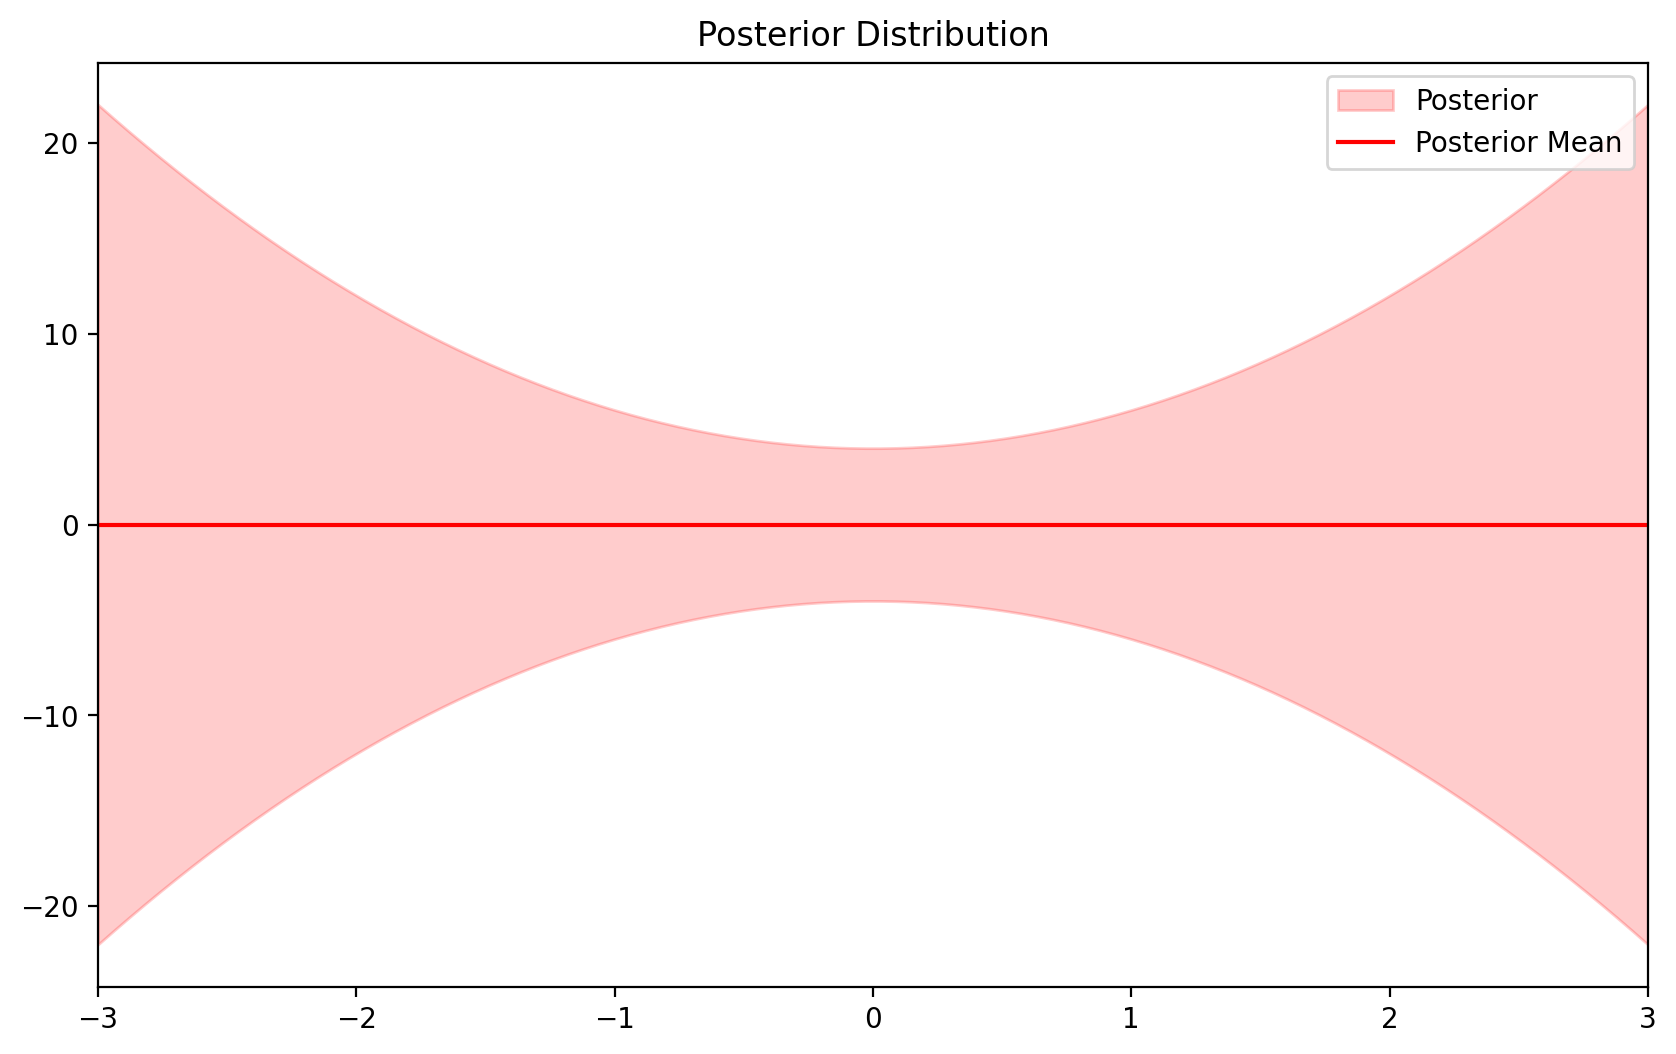

In [11]:
ax= blr.plot_predictive(x_lin)

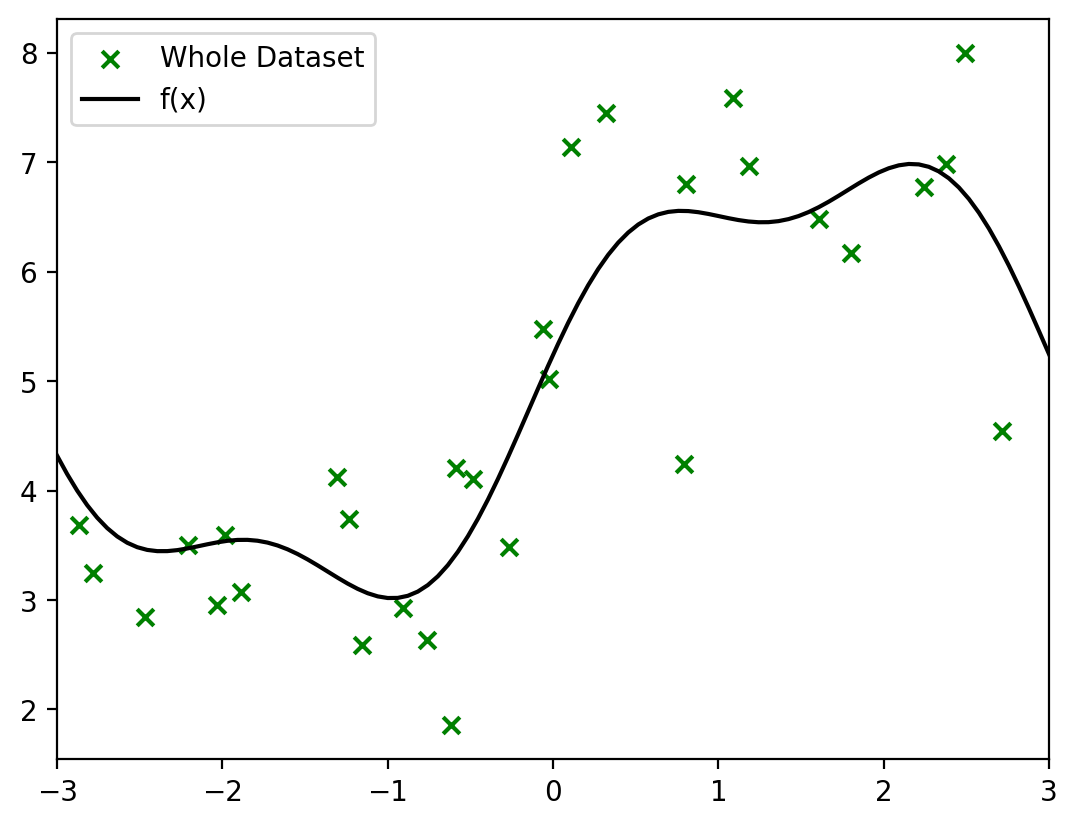

In [12]:
torch.manual_seed(0)
N_TOT = 30
X_dataset = torch.distributions.Uniform(-3, 3).sample((N_TOT, 1))
f_dataset = f(X_dataset)
y_dataset = f_dataset + torch.distributions.Normal(0, 1.0).sample((N_TOT, 1))

def plot_dataset(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Plot the dataset
    ax.scatter(X_dataset.numpy(), y_dataset.numpy(), c='g', marker='x', label='Whole Dataset')
    ax.plot(x_lin, f(x_lin), label='f(x)',c = 'k')
    ax.legend()
    ax.set_xlim(-3, 3)
    
plot_dataset()

In [13]:
# Add the first 1 data points to the model
d = 2
blr = BLR(*init_prior_params(d))
blr.update(X_dataset[:1], y_dataset[:1])

In [14]:
blr

BLR(mu=tensor([ 1.2552, -0.0282, -0.0564,  1.2539,  0.5517,  1.1274]),
 sigma=tensor([[ 7.5003e-01,  5.6144e-03,  1.1225e-02, -2.4972e-01, -1.0987e-01,
         -2.2453e-01],
        [ 5.6144e-03,  9.9987e-01, -2.5212e-04,  5.6087e-03,  2.4677e-03,
          5.0430e-03],
        [ 1.1225e-02, -2.5212e-04,  9.9950e-01,  1.1214e-02,  4.9338e-03,
          1.0083e-02],
        [-2.4972e-01,  5.6087e-03,  1.1214e-02,  7.5054e-01, -1.0976e-01,
         -2.2430e-01],
        [-1.0987e-01,  2.4677e-03,  4.9338e-03, -1.0976e-01,  9.5171e-01,
         -9.8688e-02],
        [-2.2453e-01,  5.0430e-03,  1.0083e-02, -2.2430e-01, -9.8688e-02,
          7.9832e-01]]), 
sigma_noise=1.0)

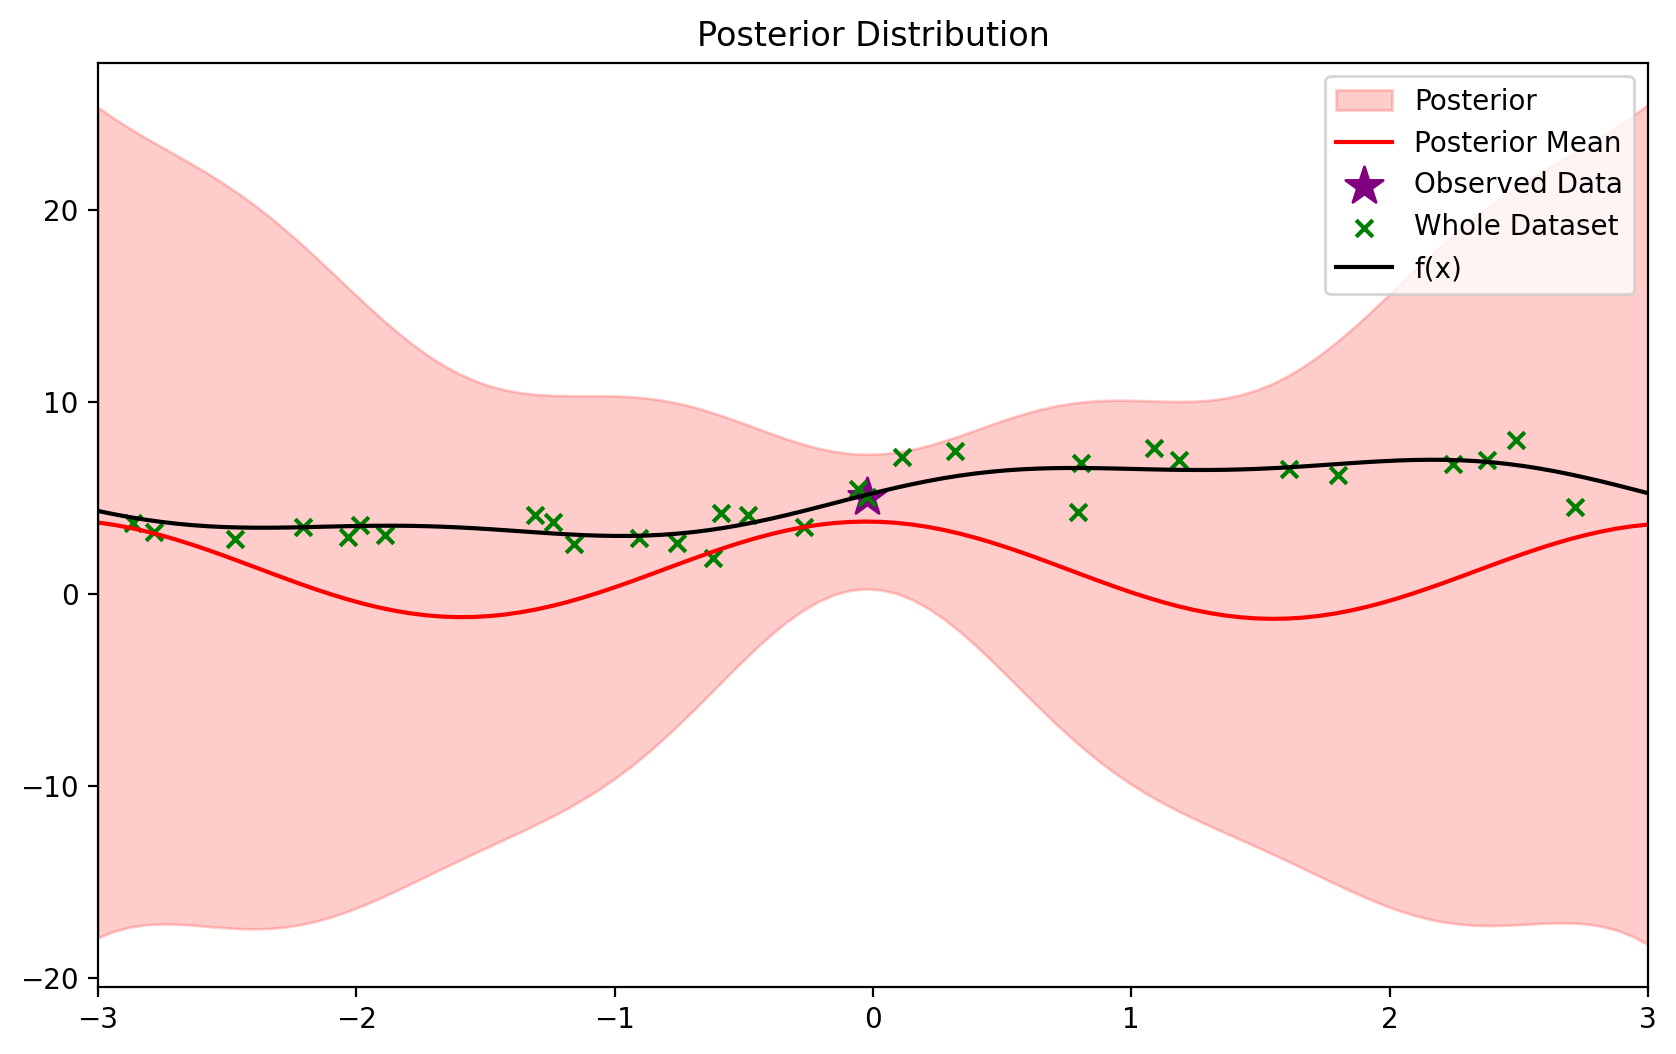

In [15]:
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)

In [16]:
# Add the next 1 data points to the model
blr.update(X_dataset[1:2], y_dataset[1:2])

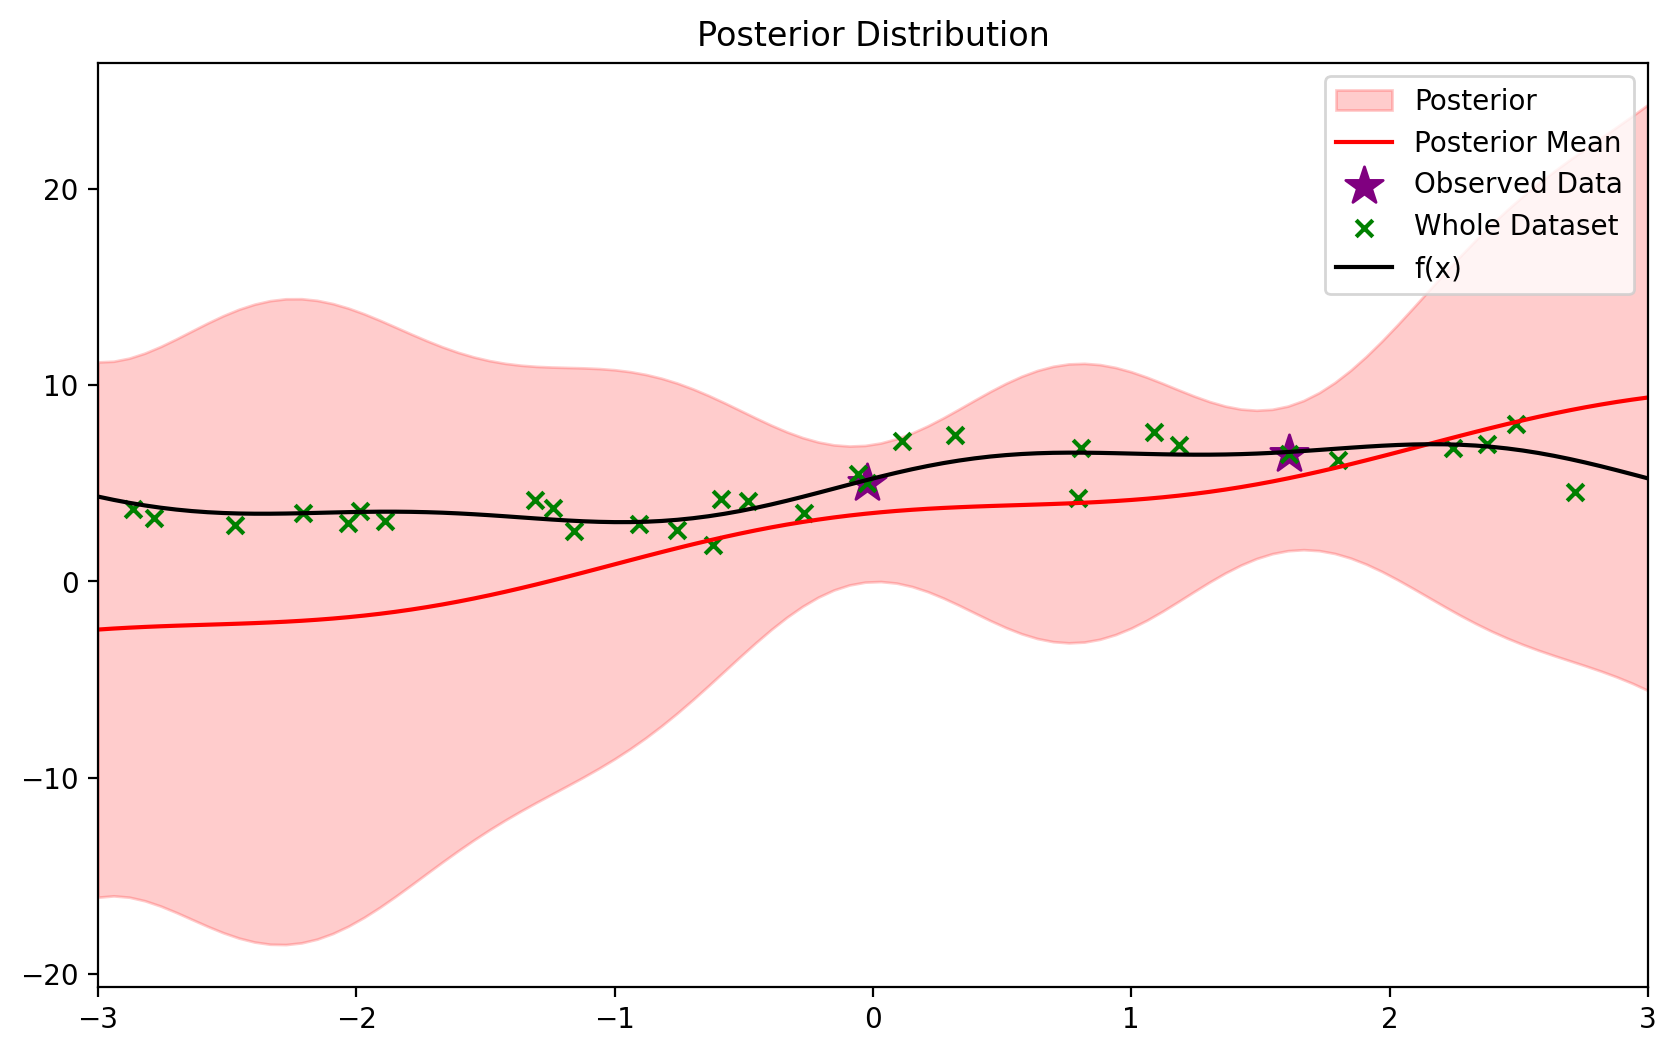

In [17]:
ax = blr.plot_predictive(x_lin)
plot_dataset(ax=ax)

In [18]:
blr

BLR(mu=tensor([ 2.7943,  1.9381, -0.1648,  0.3441,  0.0203,  0.3810]),
 sigma=tensor([[ 5.0107e-01, -3.1243e-01,  2.8769e-02, -1.0255e-01, -2.3920e-02,
         -1.0379e-01],
        [-3.1243e-01,  5.9358e-01,  2.2160e-02,  1.9360e-01,  1.1227e-01,
          1.5928e-01],
        [ 2.8769e-02,  2.2160e-02,  9.9826e-01,  8.4362e-04, -1.1228e-03,
          1.5747e-03],
        [-1.0255e-01,  1.9360e-01,  8.4362e-04,  6.6355e-01, -1.6056e-01,
         -2.9567e-01],
        [-2.3920e-02,  1.1227e-01, -1.1228e-03, -1.6056e-01,  9.2204e-01,
         -1.4037e-01],
        [-1.0379e-01,  1.5928e-01,  1.5747e-03, -2.9567e-01, -1.4037e-01,
          7.3977e-01]]), 
sigma_noise=1.0)

In [19]:
# instead, add the two data points at once
d = 2
blr_new = BLR(*init_prior(d))
blr_new.update(X_dataset[:2], y_dataset[:2])

In [20]:
blr

BLR(mu=tensor([ 2.7943,  1.9381, -0.1648,  0.3441,  0.0203,  0.3810]),
 sigma=tensor([[ 5.0107e-01, -3.1243e-01,  2.8769e-02, -1.0255e-01, -2.3920e-02,
         -1.0379e-01],
        [-3.1243e-01,  5.9358e-01,  2.2160e-02,  1.9360e-01,  1.1227e-01,
          1.5928e-01],
        [ 2.8769e-02,  2.2160e-02,  9.9826e-01,  8.4362e-04, -1.1228e-03,
          1.5747e-03],
        [-1.0255e-01,  1.9360e-01,  8.4362e-04,  6.6355e-01, -1.6056e-01,
         -2.9567e-01],
        [-2.3920e-02,  1.1227e-01, -1.1228e-03, -1.6056e-01,  9.2204e-01,
         -1.4037e-01],
        [-1.0379e-01,  1.5928e-01,  1.5747e-03, -2.9567e-01, -1.4037e-01,
          7.3977e-01]]), 
sigma_noise=1.0)

In [21]:
blr_new

BLR(mu=tensor([ 2.7943,  1.9381, -0.1648,  0.3441,  0.0203,  0.3810]),
 sigma=tensor([[ 5.0107e-01, -3.1243e-01,  2.8769e-02, -1.0255e-01, -2.3920e-02,
         -1.0379e-01],
        [-3.1243e-01,  5.9358e-01,  2.2160e-02,  1.9360e-01,  1.1227e-01,
          1.5928e-01],
        [ 2.8769e-02,  2.2160e-02,  9.9826e-01,  8.4362e-04, -1.1228e-03,
          1.5747e-03],
        [-1.0255e-01,  1.9360e-01,  8.4362e-04,  6.6355e-01, -1.6056e-01,
         -2.9567e-01],
        [-2.3920e-02,  1.1227e-01, -1.1228e-03, -1.6056e-01,  9.2204e-01,
         -1.4037e-01],
        [-1.0379e-01,  1.5928e-01,  1.5747e-03, -2.9567e-01, -1.4037e-01,
          7.3977e-01]]), 
sigma_noise=1.0)

<AxesSubplot:title={'center':'Posterior Distribution'}>

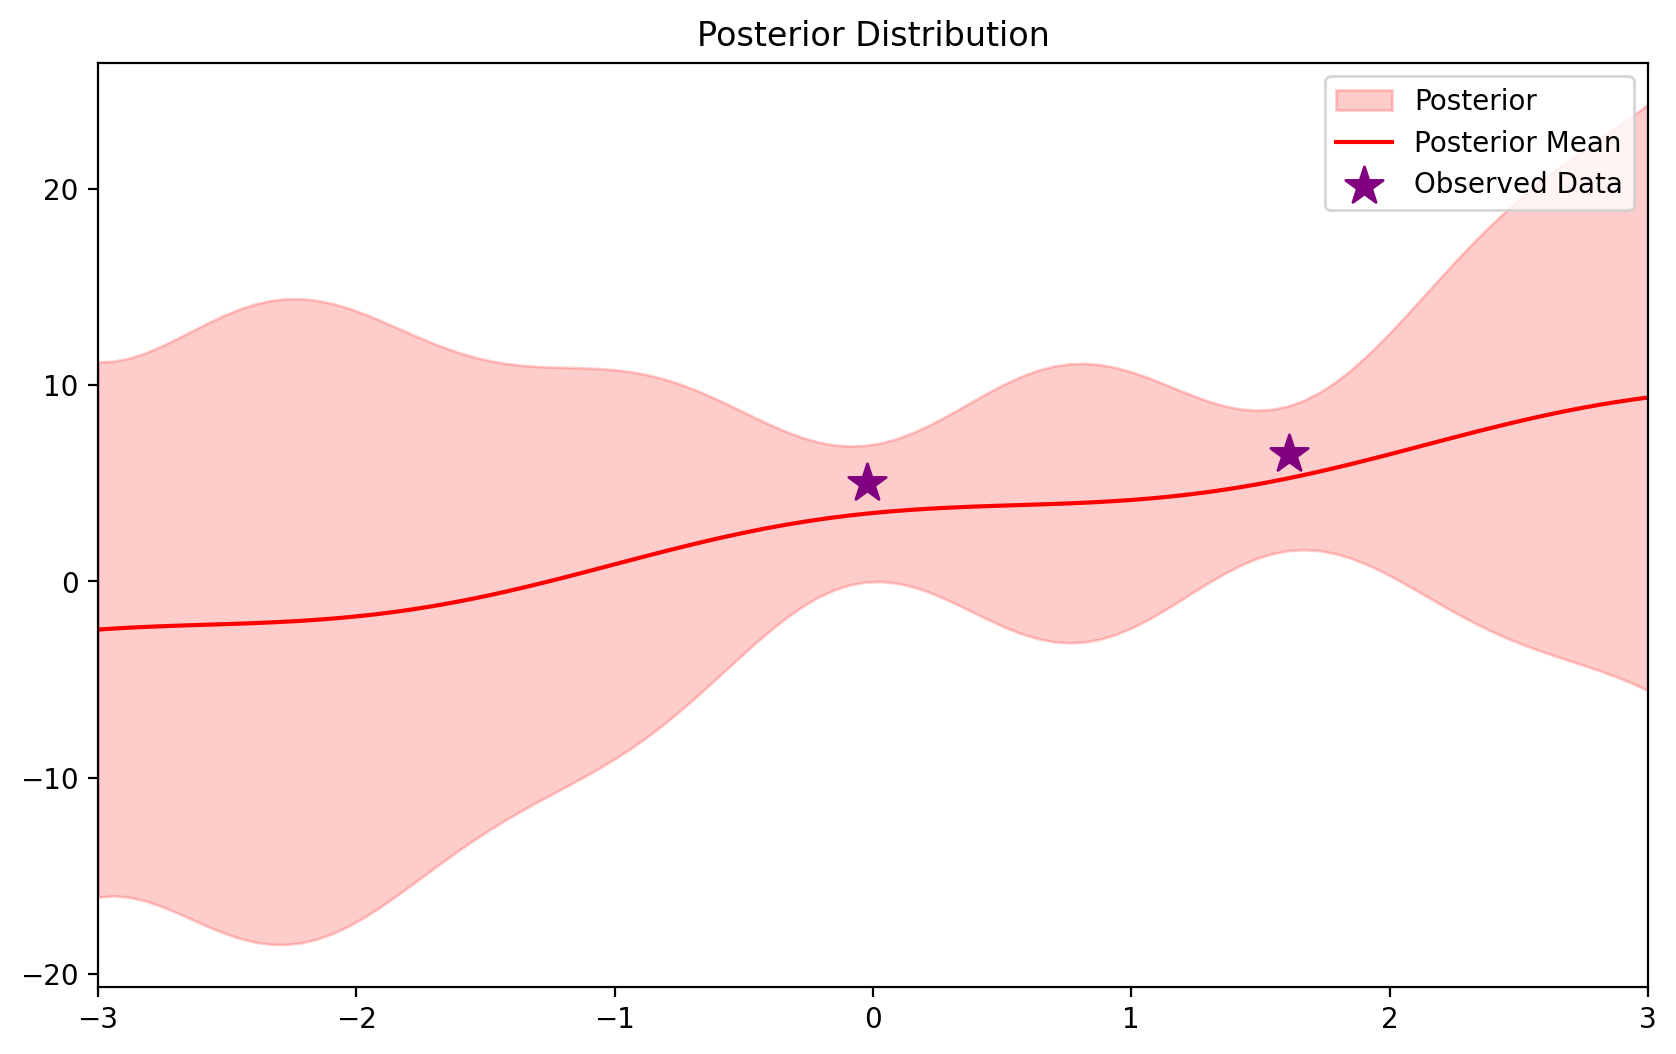

In [22]:
blr_new.plot_predictive(x_lin)

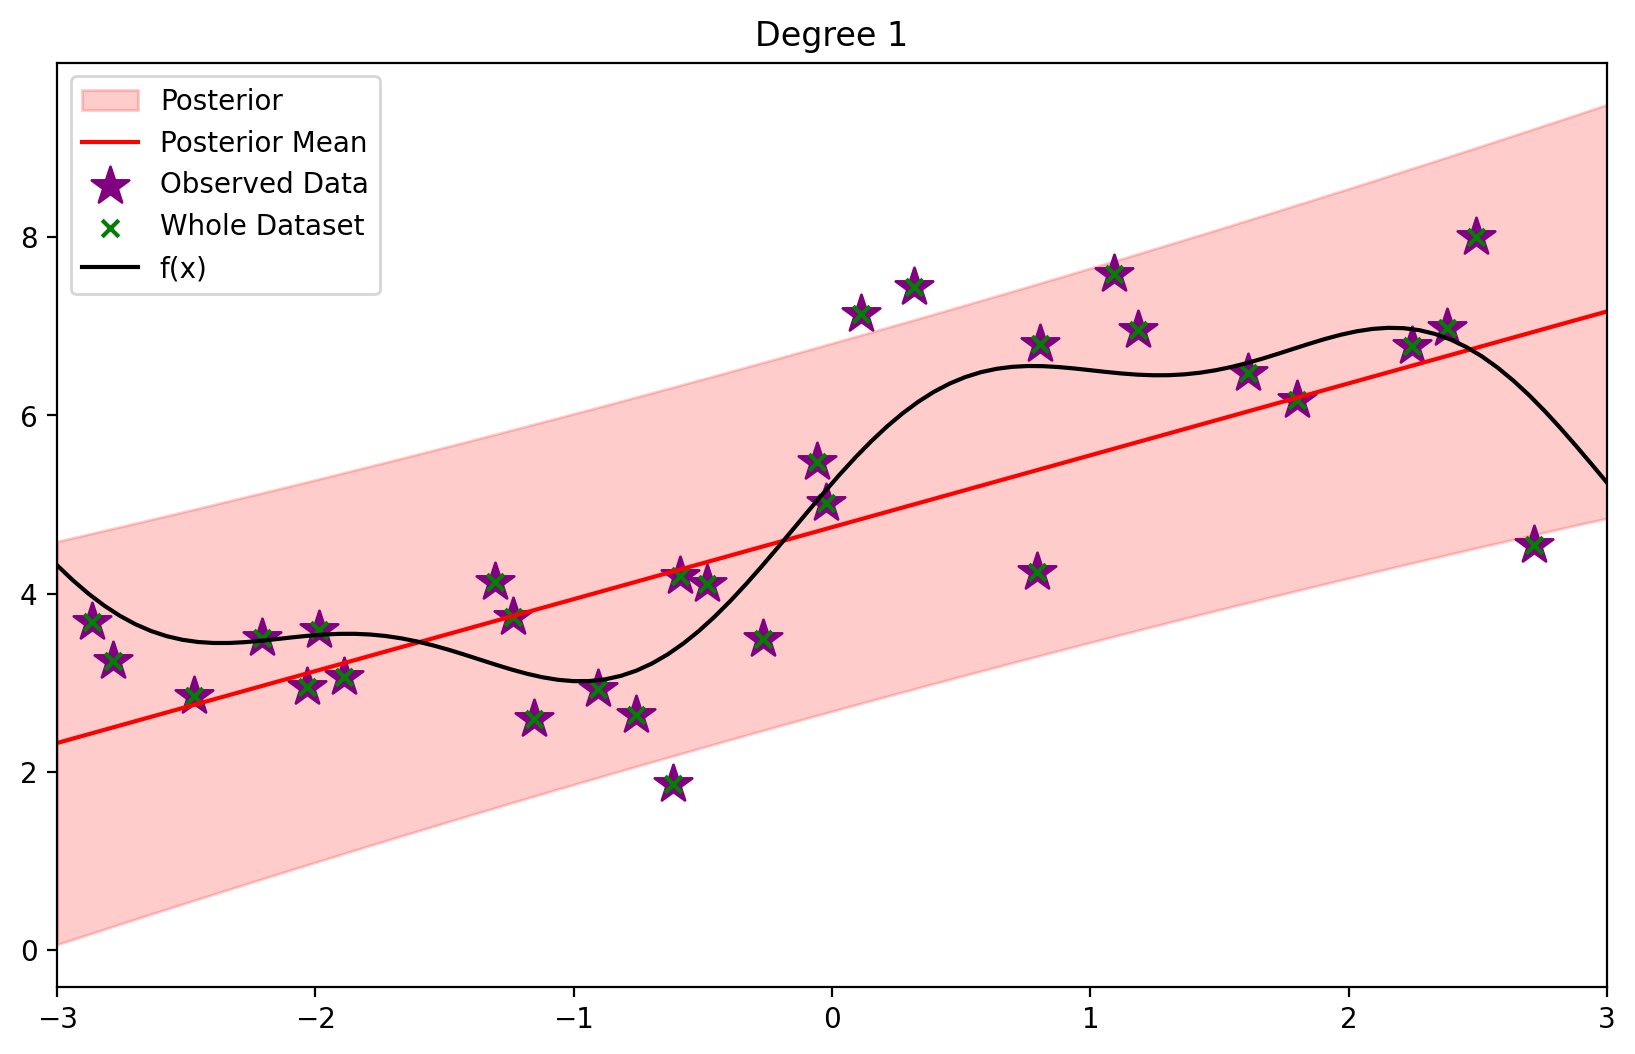

In [23]:
# Entire dataset
def plot_fit(degree):
    blr = BLR(*init_prior_params(degree))
    blr.update(X_dataset, y_dataset)
    ax = blr.plot_predictive(x_lin)
    plot_dataset(ax=ax)
    plt.title(f'Degree {degree}')
    plt.show()

plot_fit(1)

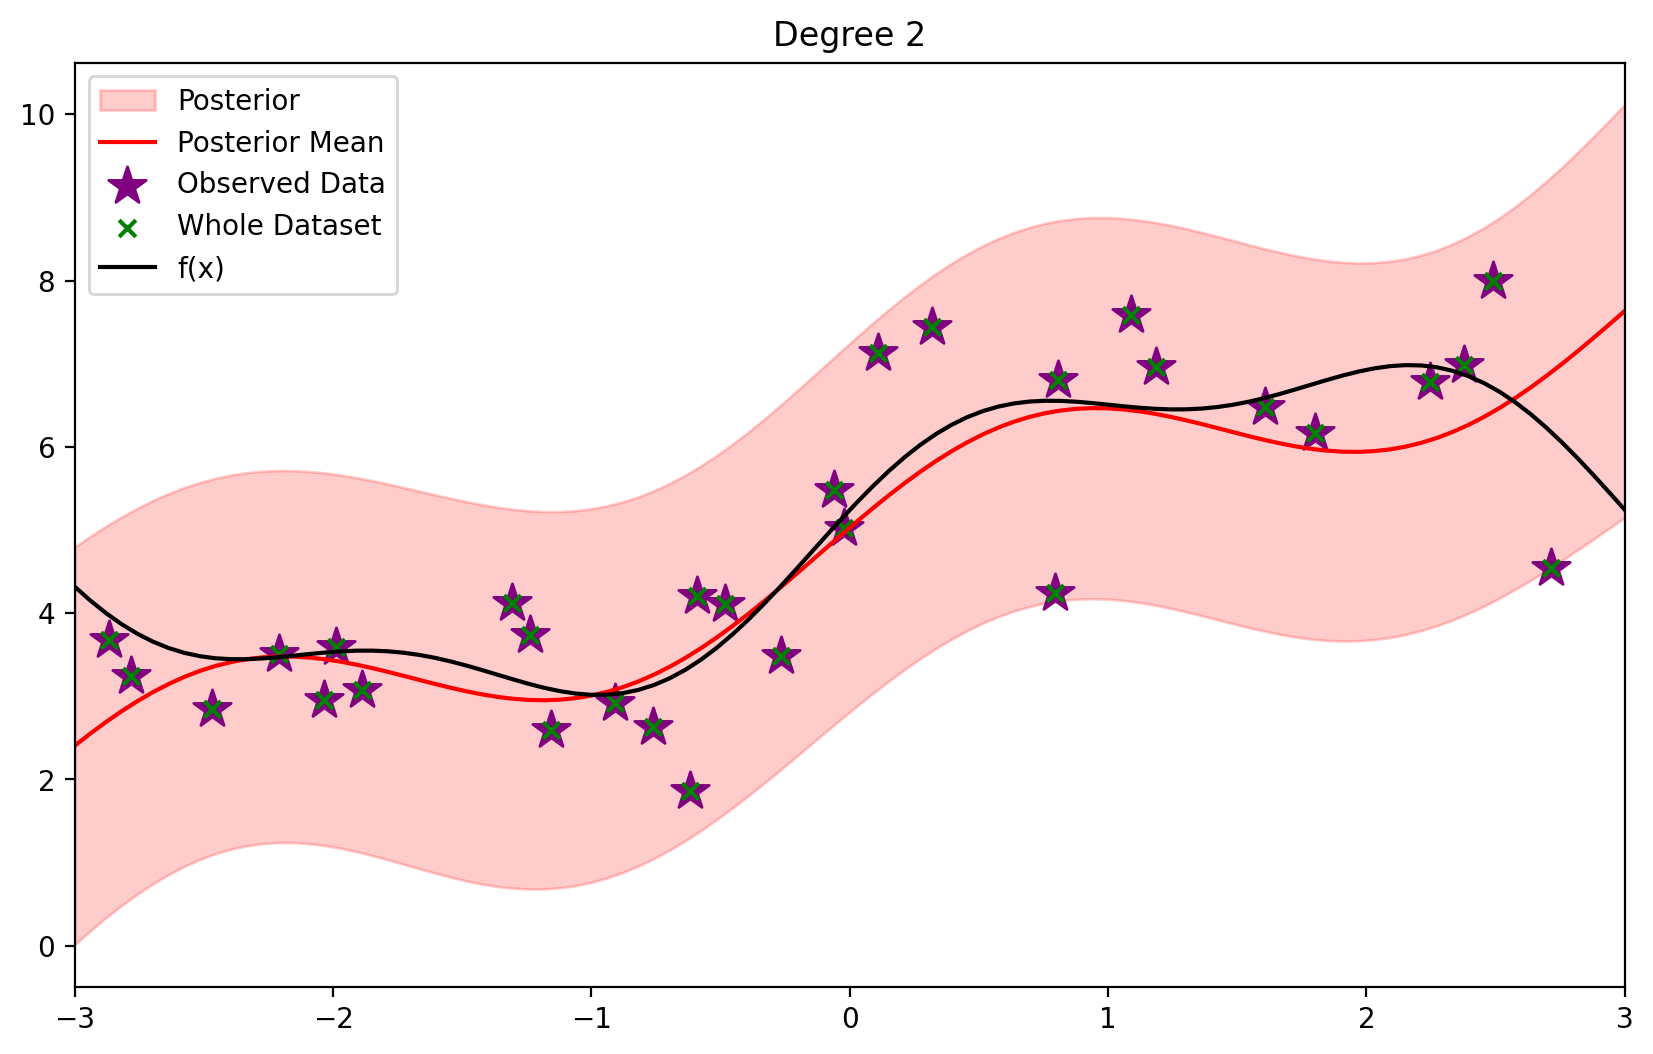

In [24]:
plot_fit(2)

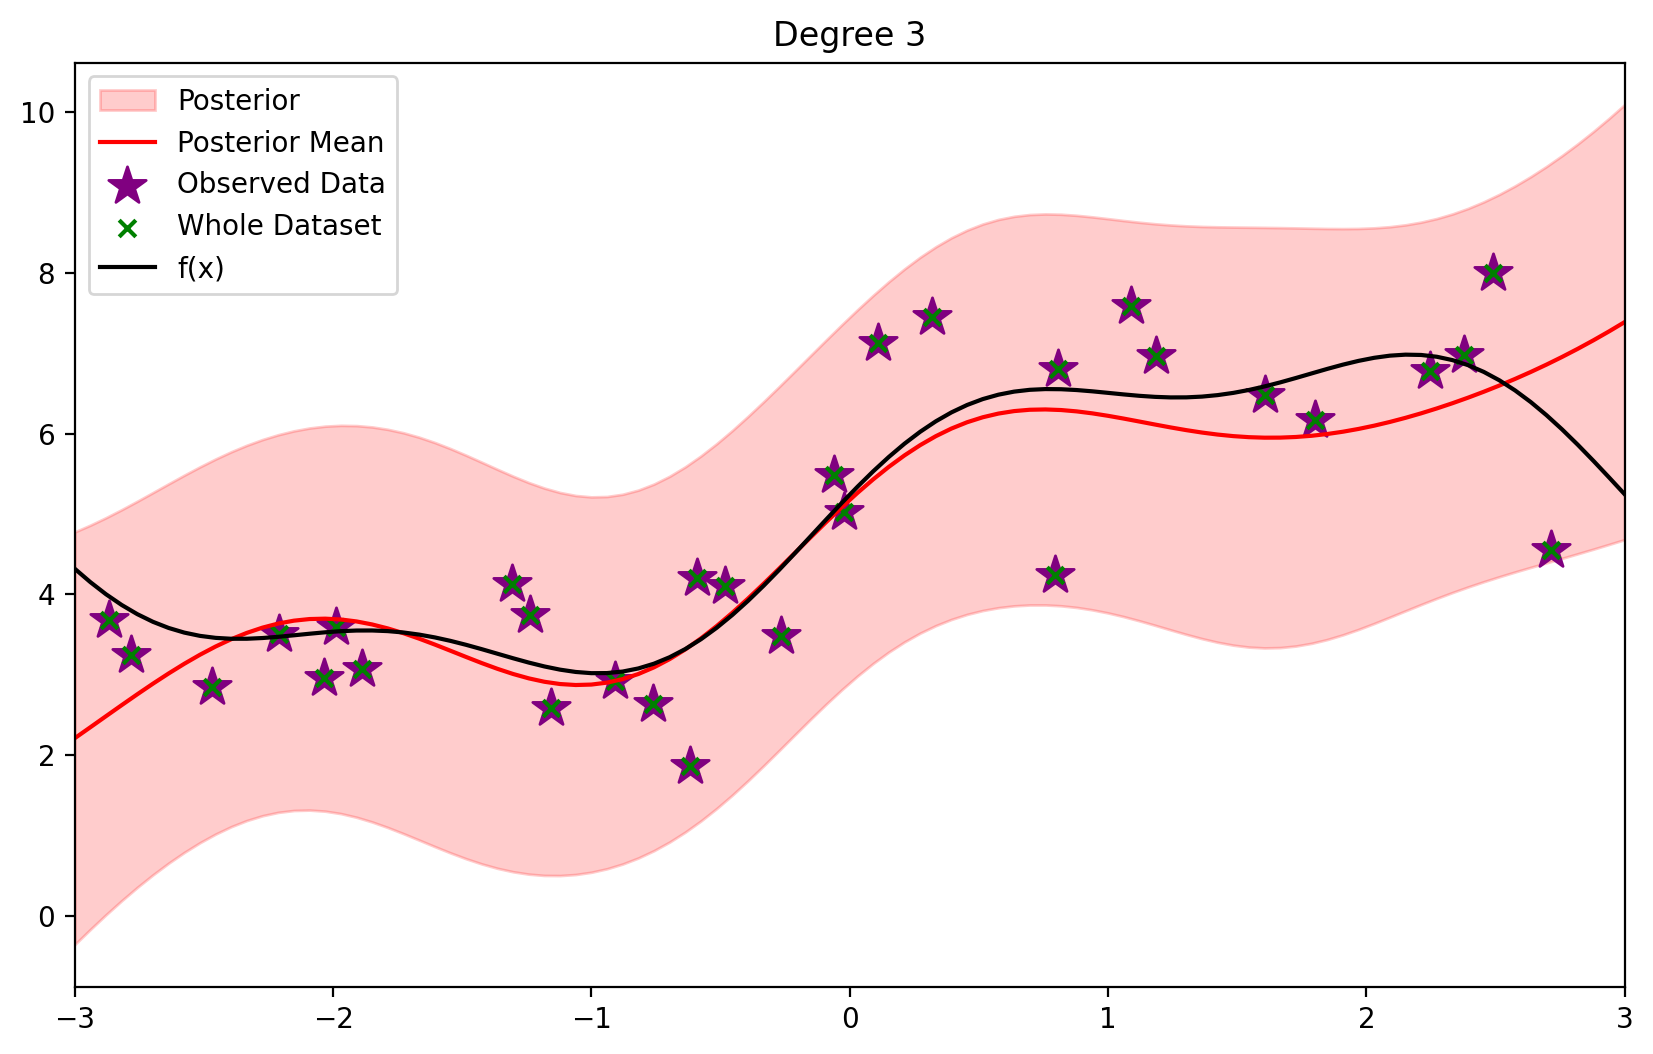

In [25]:
plot_fit(3)

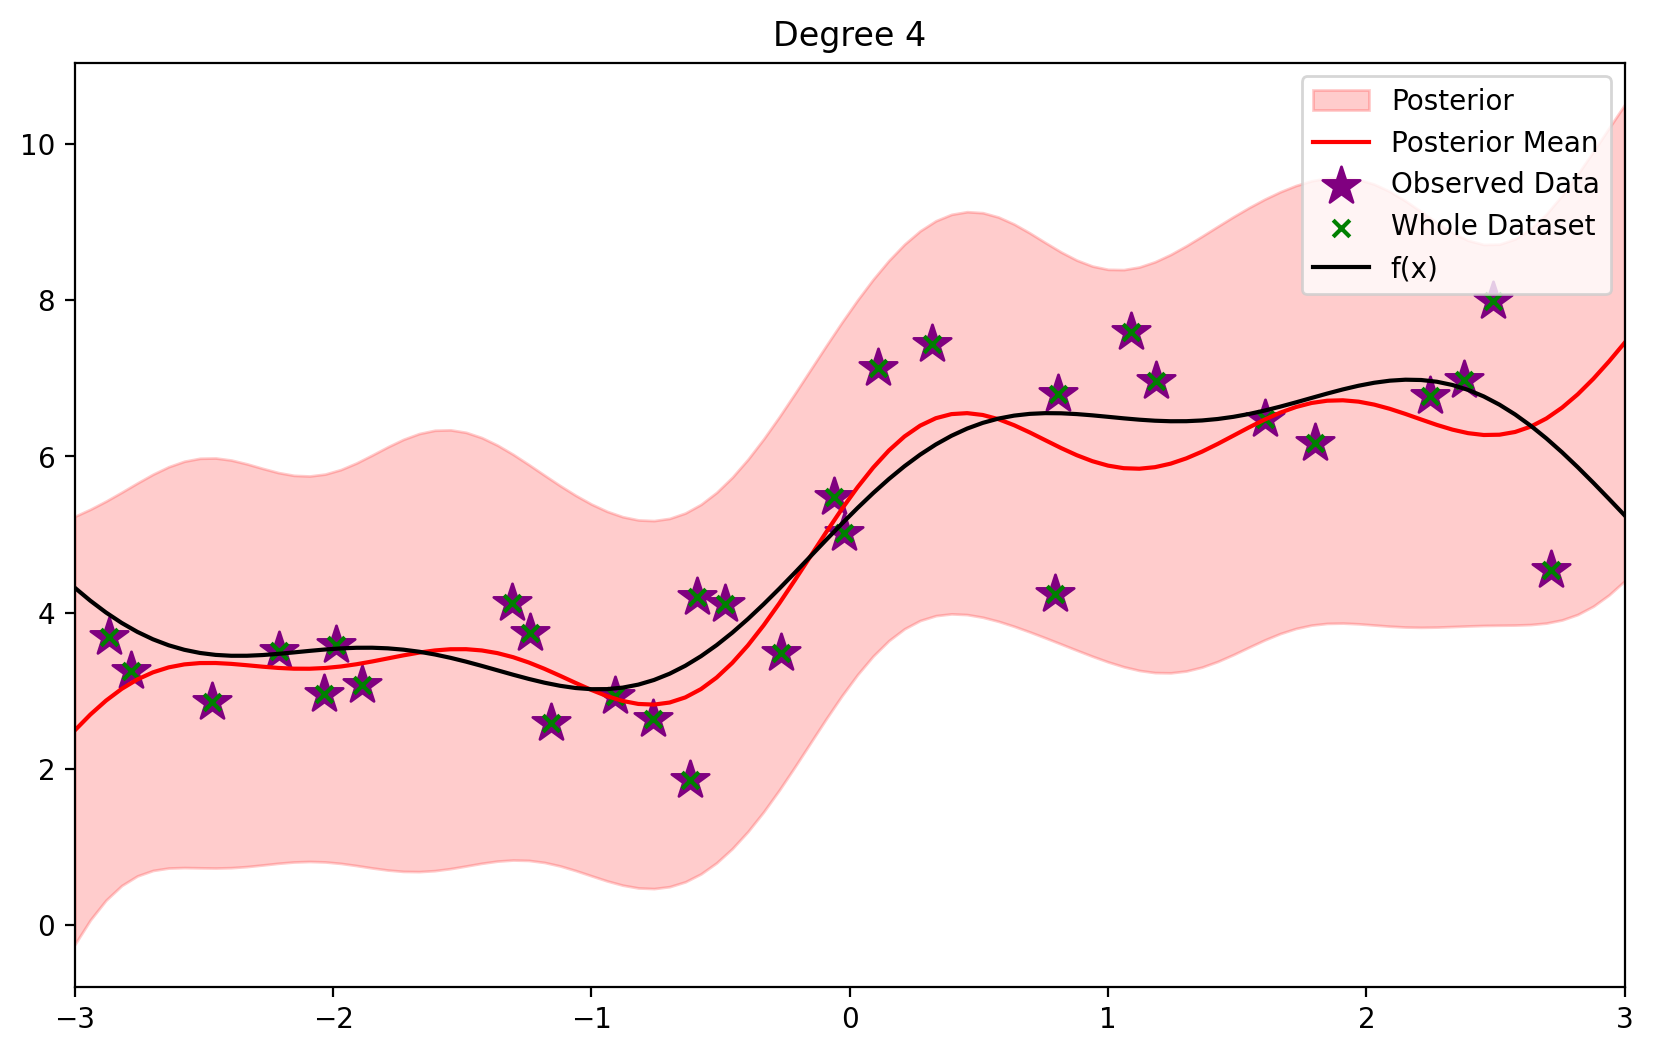

In [26]:
plot_fit(4)

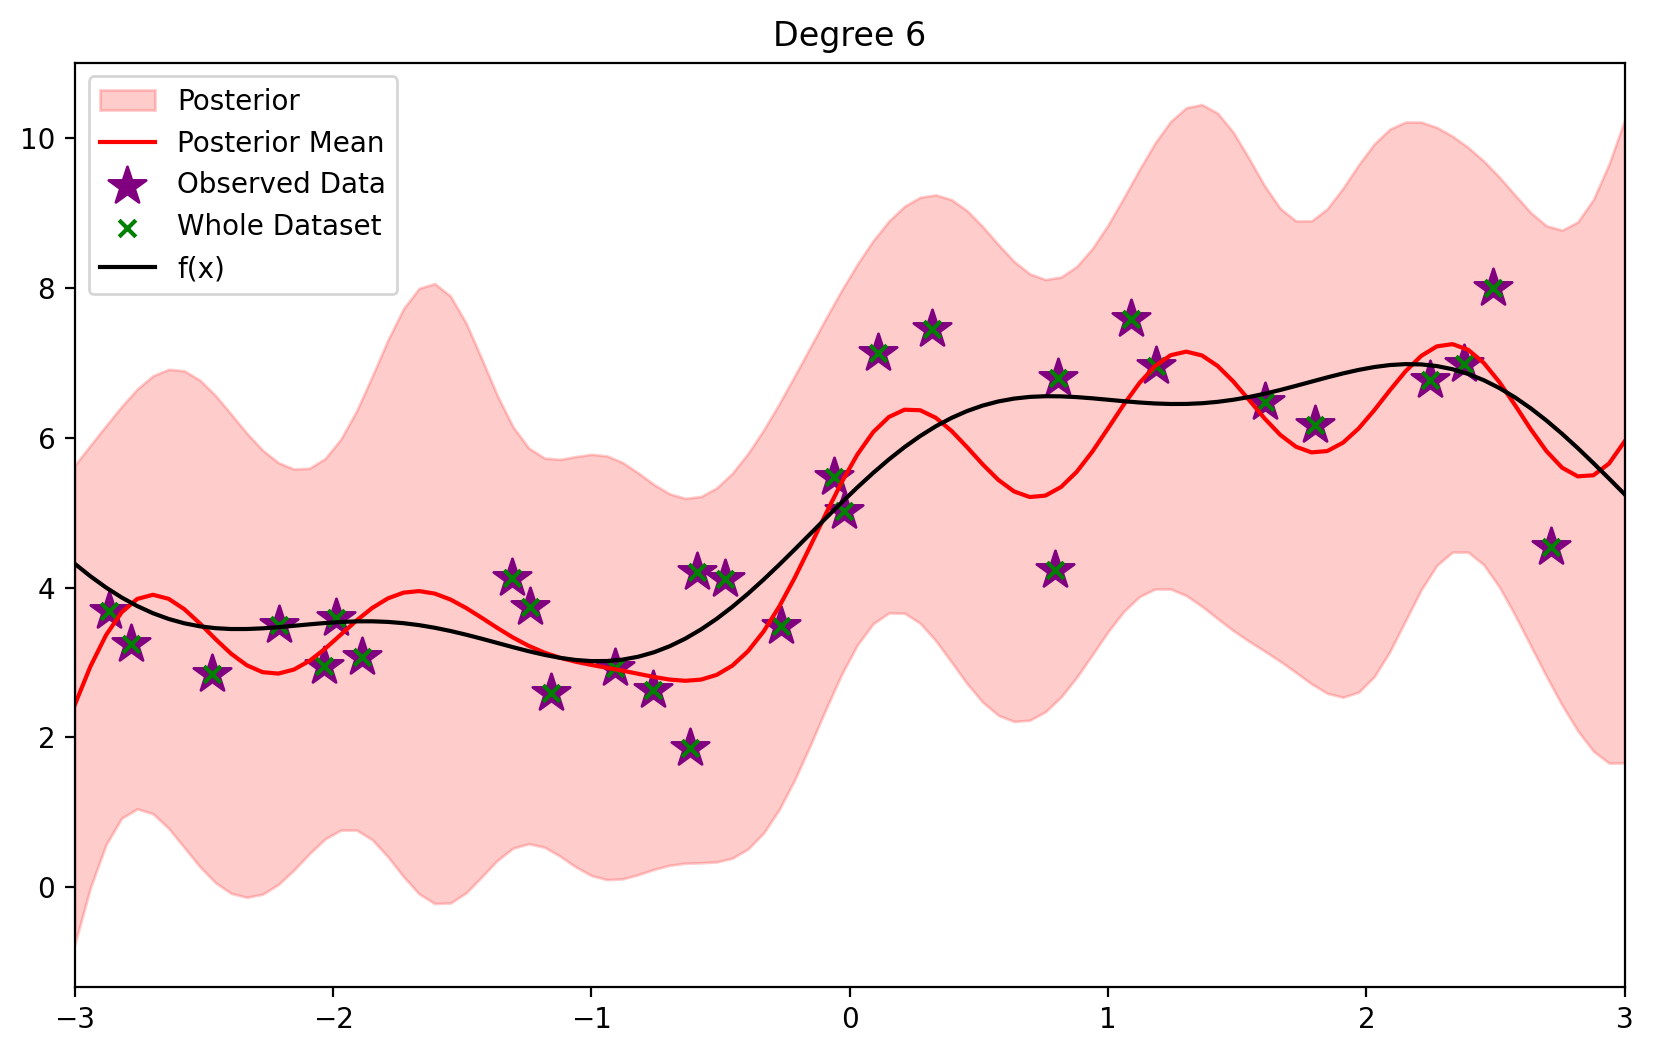

In [27]:
plot_fit(6)

In [28]:
d = 2
blr = BLR(*init_prior_params(d))

# Fit first 2 points
blr.update(X_dataset[:2], y_dataset[:2])

In [29]:
blr.current_mean

tensor([ 2.7943,  1.9381, -0.1648,  0.3441,  0.0203,  0.3810])

<AxesSubplot:title={'center':'Posterior Distribution'}>

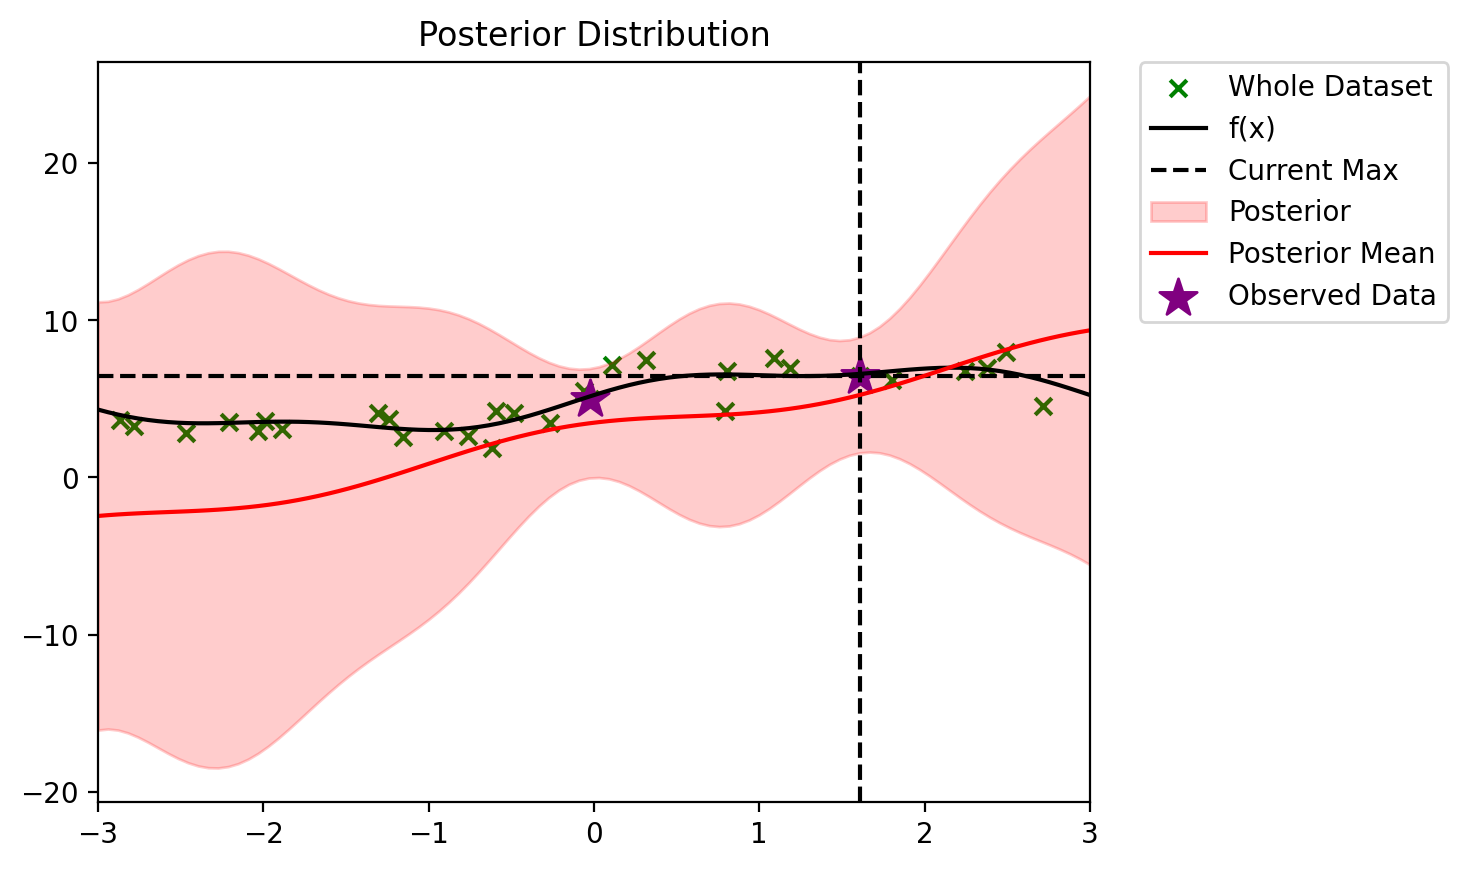

In [30]:
def plot_maximum(blr, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    # Plot the dataset
    ax.scatter(X_dataset.numpy(), y_dataset.numpy(), c='g', marker='x', label='Whole Dataset')
    ax.plot(x_lin, f(x_lin), label='f(x)',c = 'k')
    ax.set_xlim(-3, 3)
    
    # Plot the current maximum
    y_max = blr.y_total.max()
    x_max = blr.X_total[blr.y_total.argmax()]

    ax.axhline(y_max, c='k', linestyle='--', label='Current Max')
    ax.axvline(x_max, c='k', linestyle='--')
    
    # Plot BLR predictive
    ax = blr.plot_predictive(x_lin, ax=ax)
    
    # Put legend outside of plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    return ax

plot_maximum(blr)

In [31]:
def plot_maximum_and_acq(blr, acq_fn, candidate_points_x):
    
    fig, ax = plt.subplots(nrows=2, sharex=True)
    
    plot_maximum(blr, ax=ax[0])
    # Mark locations of candidate points on PI plot
    ax[1].scatter(candidate_points_x, torch.zeros_like(candidate_points_x), c='r', marker='x', label='Candidate Points')
    alpha = acq_fn(blr, x_lin, blr.y_total.max())
    ax[1].plot(x_lin, alpha, label=r'$\alpha_{PI}$')
    # legend outside of plot
    
    # Chosen candidate point
    alp_candidate = acq_fn(blr, candidate_points_x, blr.y_total.max())
    x_candidate = candidate_points_x[alp_candidate.argmax()]
    ax[1].axvline(x_candidate, c='k', linestyle='--', label='Chosen Candidate')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)



In [32]:
def plot_filled_cdf(mu, sigma, above):
    # Create a normal distribution with the specified mean and standard deviation
    normal_dist = dist.Normal(mu, sigma)

    # Generate a range of y values
    y_values = torch.linspace(mu - 10 * sigma, mu + 10 * sigma, 2000)

    # Calculate the probability density at each y value
    pdf_values = normal_dist.log_prob(y_values).exp()

    # Create a mask to select values above the specified "above" value
    mask = y_values >= above

    # Plot the vertical line at "above"
    plt.axhline(above, c='k', linestyle='--', label=f'Above {above}')

    # Plot the PDF
    plt.plot(pdf_values.numpy(), y_values.numpy(), label='PDF')
    
    z0 = torch.tensor((mu - above)/sigma)
    phi = dist.Normal(0, 1).cdf(z0)

    # Fill the area under the CDF curve for values above "above"
    plt.fill_betweenx(y_values.numpy(), pdf_values.numpy(), 
                      where=mask, alpha=0.2, color='r', 
                      label=f'CDF Above {above} = {phi:.4f}')

    plt.xlabel('PDF')
    plt.ylabel('Y')
    plt.legend()
    plt.show()


In [33]:
import ipywidgets as widgets
from IPython.display import display


In [34]:
# Create interactive widgets for mu, sigma, and above
mu_widget = widgets.FloatSlider(value=0.5, min=-1, max=1, step=0.1, description='Mean:')
sigma_widget = widgets.FloatSlider(value=0.5, min=0.1, max=2, step=0.1, description='Standard Deviation:')
above_widget = widgets.FloatSlider(value=0.6, min=-1, max=1, step=0.1, description='Above Value:')

# Create an interactive output
out = widgets.interactive_output(plot_filled_cdf, {'mu': mu_widget, 'sigma': sigma_widget, 'above': above_widget})

# Display the widgets and output
display(widgets.VBox([mu_widget, sigma_widget, above_widget, out]))

In [35]:
def alpha_PI(model, x_lin, y_max, eps=1e-1):
    """
    model: BLR model
    x_lin: (n_points, d)
    y_max: current maximum
    eps: exploration parameter
    """
    
    # Get the predictive mean and variance
    predictive_mean, predictive_variance = model.predict(x_lin)
  
    # Calculate the PI acquisition function
    z0 = (predictive_mean - y_max - eps) / torch.sqrt(predictive_variance)
    
    # Evaluate CDF of the standard normal at alpha
    alpha = torch.distributions.Normal(0, 1).cdf(z0)
    
    return alpha

In [36]:
def setdiff1d(a, b):
    mask = ~a.unsqueeze(1).eq(b).any(dim=1)
    return torch.masked_select(a, mask)

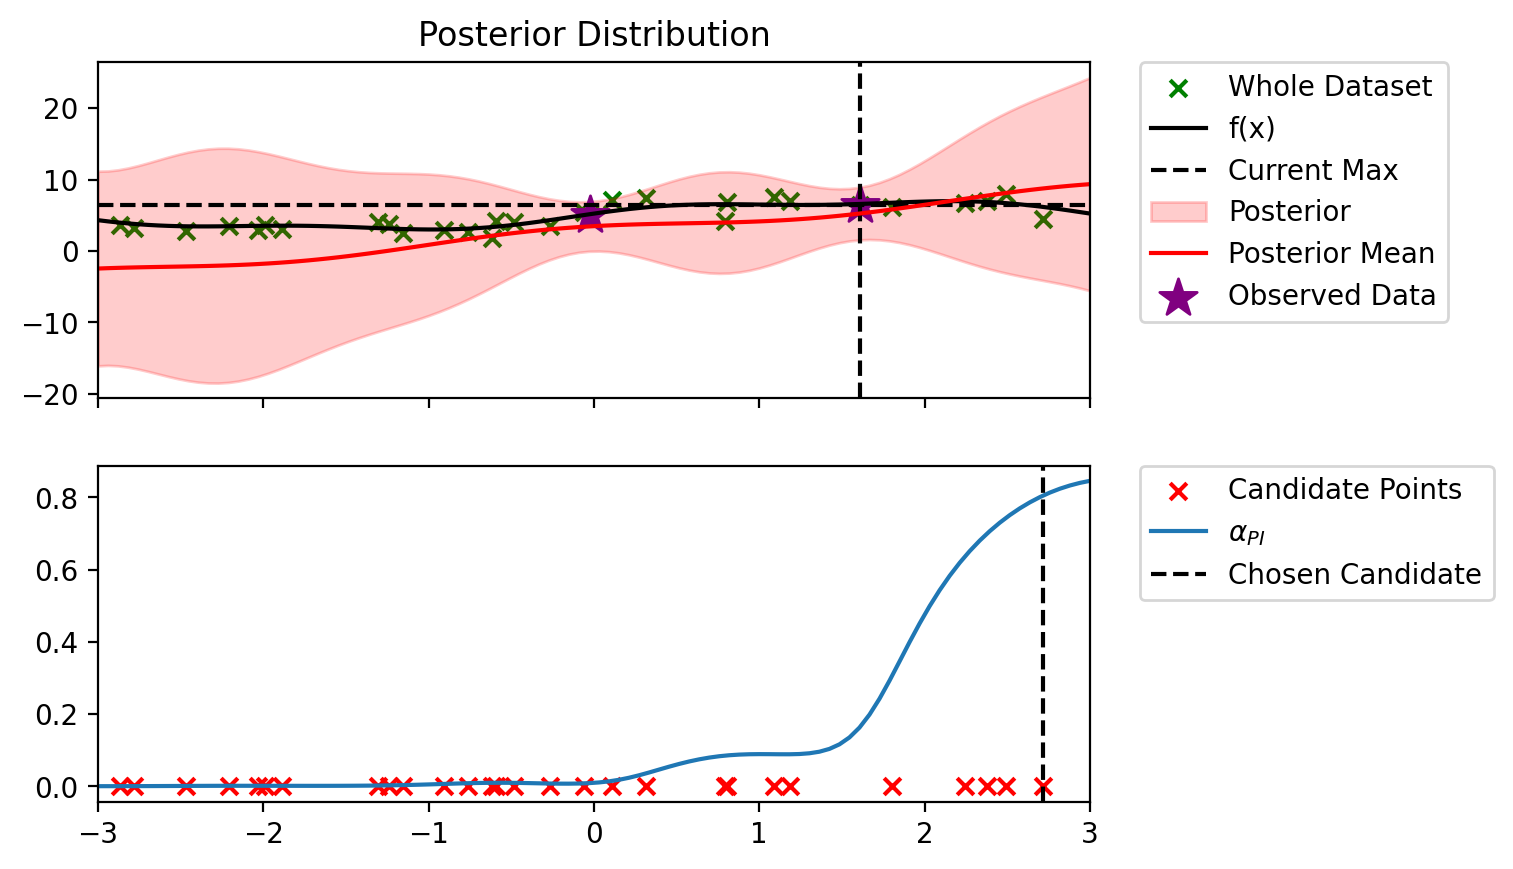

In [37]:
alpha = alpha_PI(blr, x_lin, blr.y_total.max())
candidate_points_x = setdiff1d(X_dataset, blr.X_total).reshape(-1, 1)

plot_maximum_and_acq(blr, alpha_PI, candidate_points_x)

/tmp/ipykernel_163481/1988263787.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z0 = torch.tensor((mu - above)/sigma)


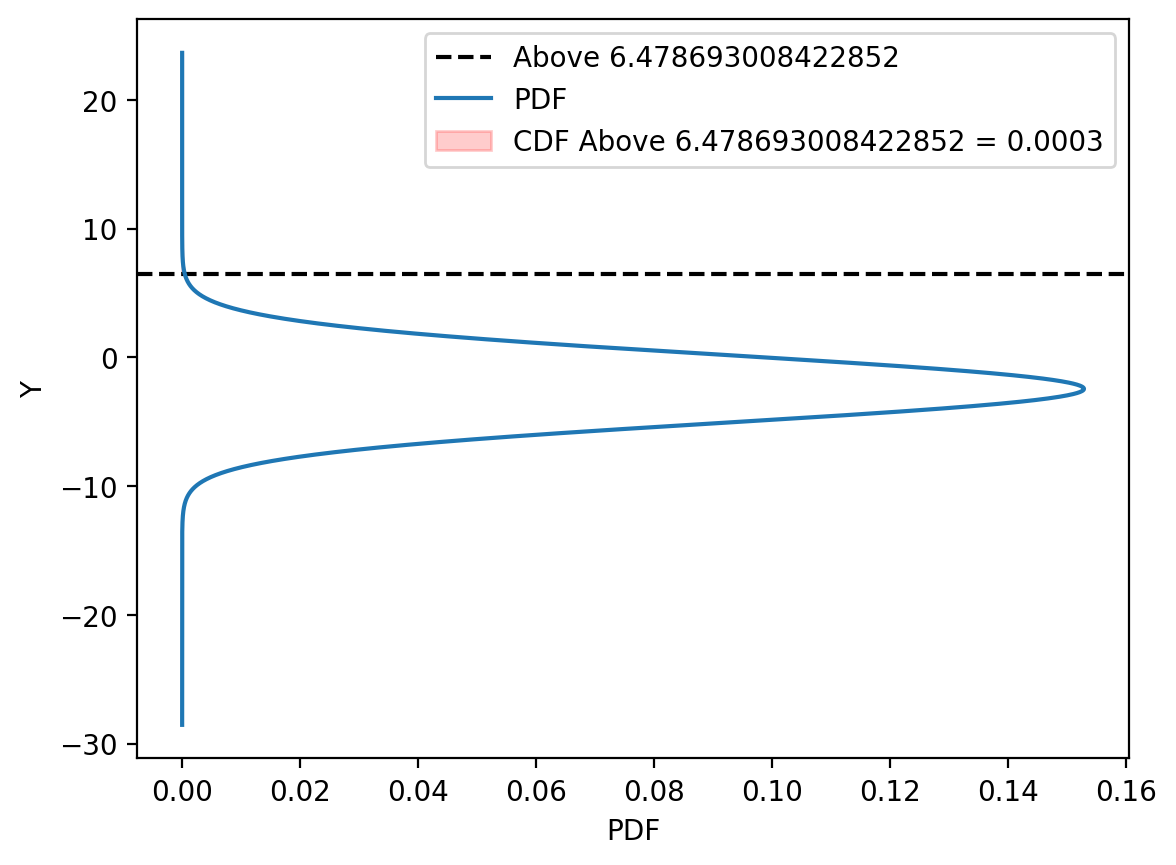

In [38]:
y_max = blr.y_total.max()
mu_0, sigma_0 = blr.predict(x_lin[0:1])
above = y_max 
plot_filled_cdf(mu_0.item(), sigma_0.item()**0.5, above)

Iteration 1
y maximum till now: 6.478693008422852
Iteration 2
y maximum till now: 7.5902419090271
Iteration 3
y maximum till now: 7.5902419090271
Iteration 4
y maximum till now: 7.5902419090271
Iteration 5
y maximum till now: 7.5902419090271
Iteration 6
y maximum till now: 7.5902419090271
Iteration 7
y maximum till now: 7.997363090515137
Iteration 8
y maximum till now: 7.997363090515137
Iteration 9
y maximum till now: 7.997363090515137
Iteration 10
y maximum till now: 7.997363090515137


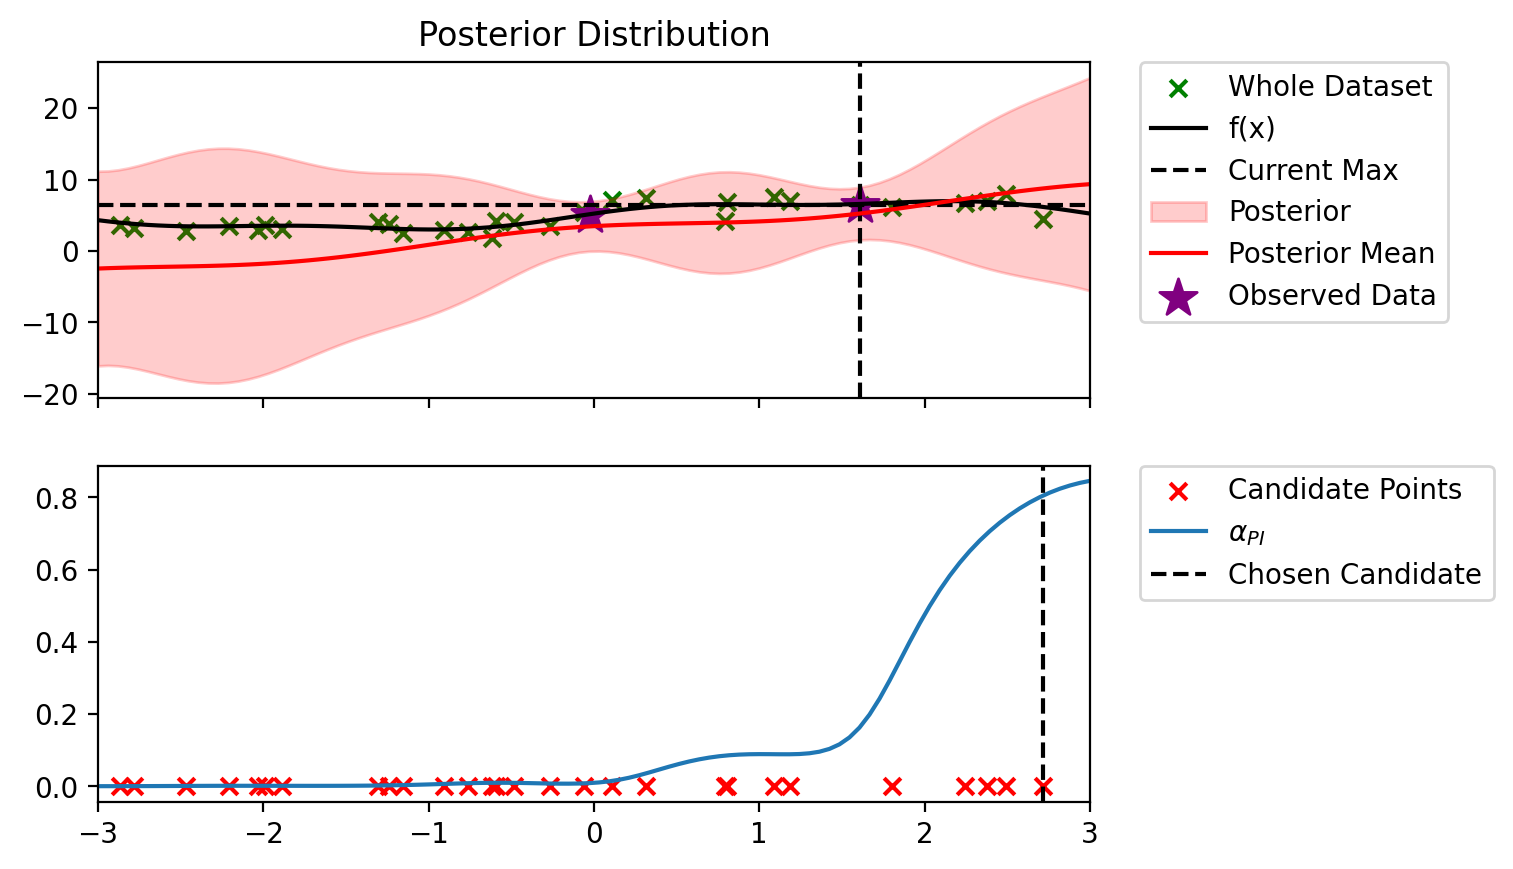

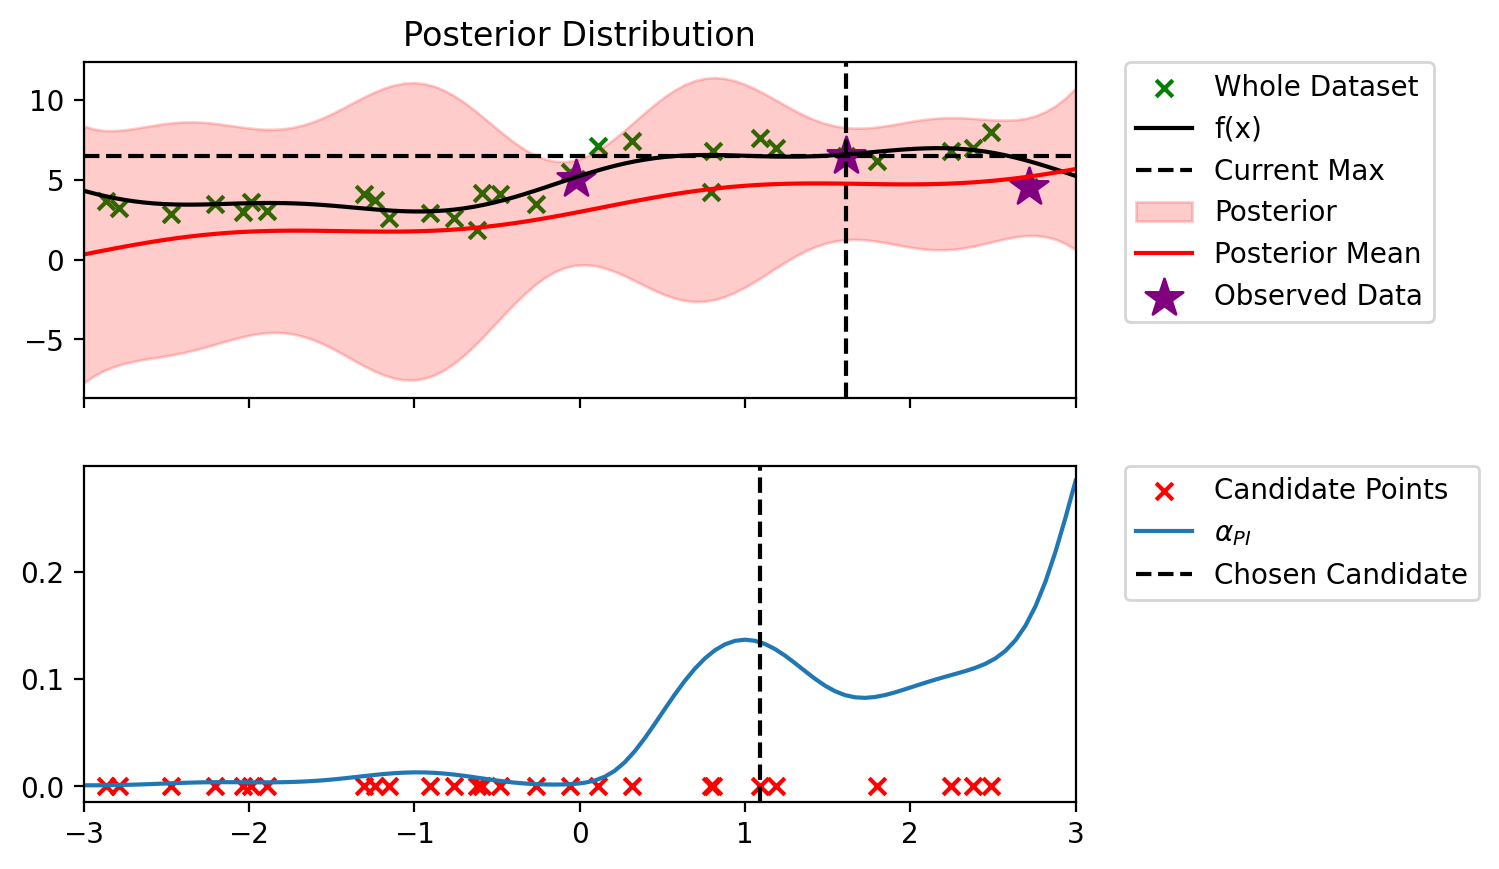

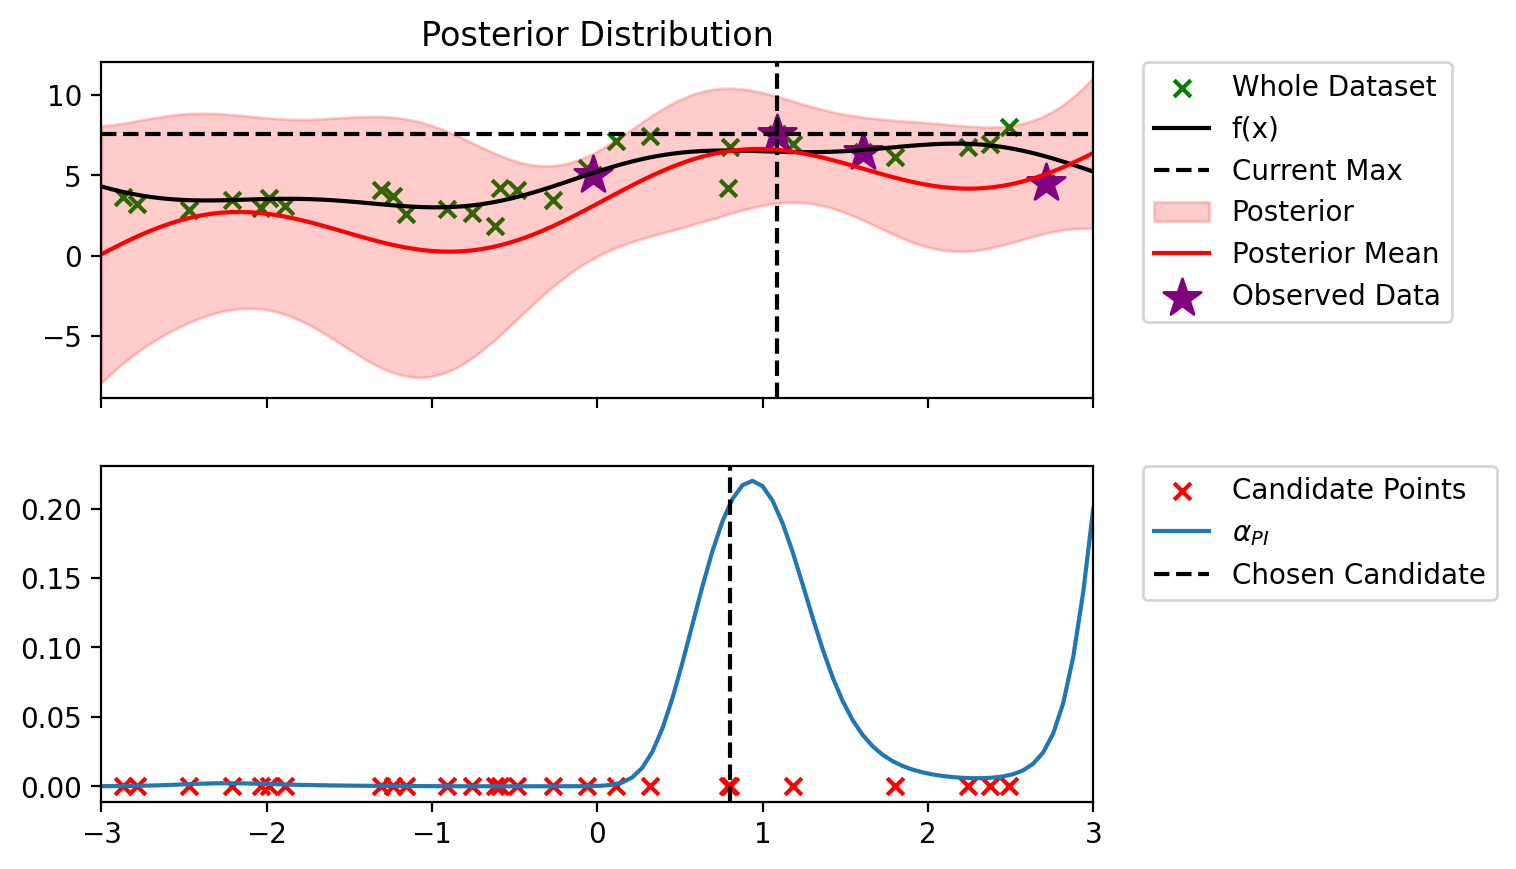

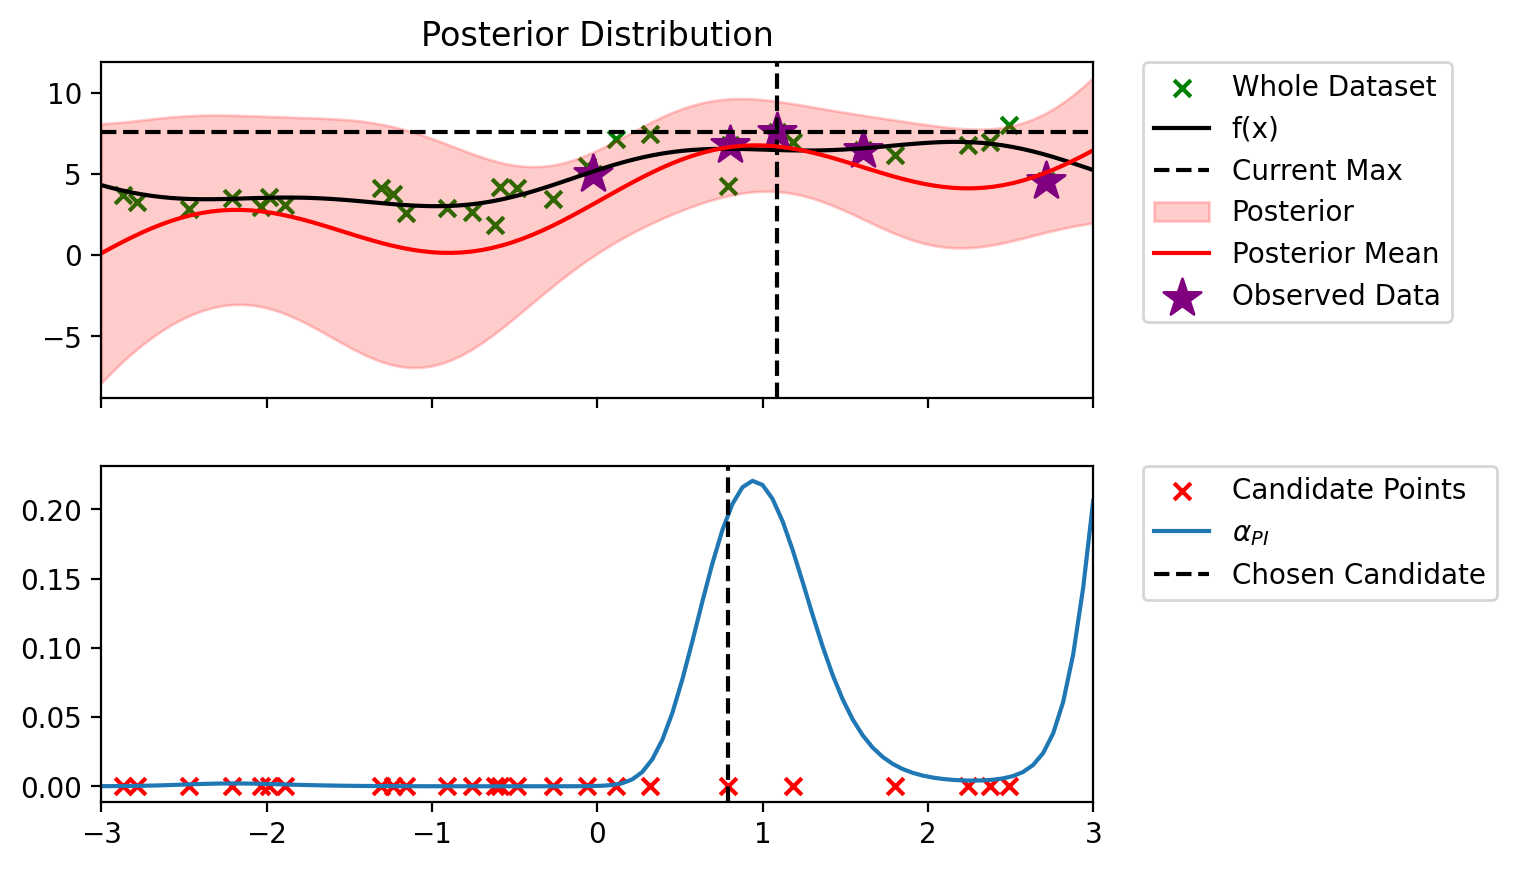

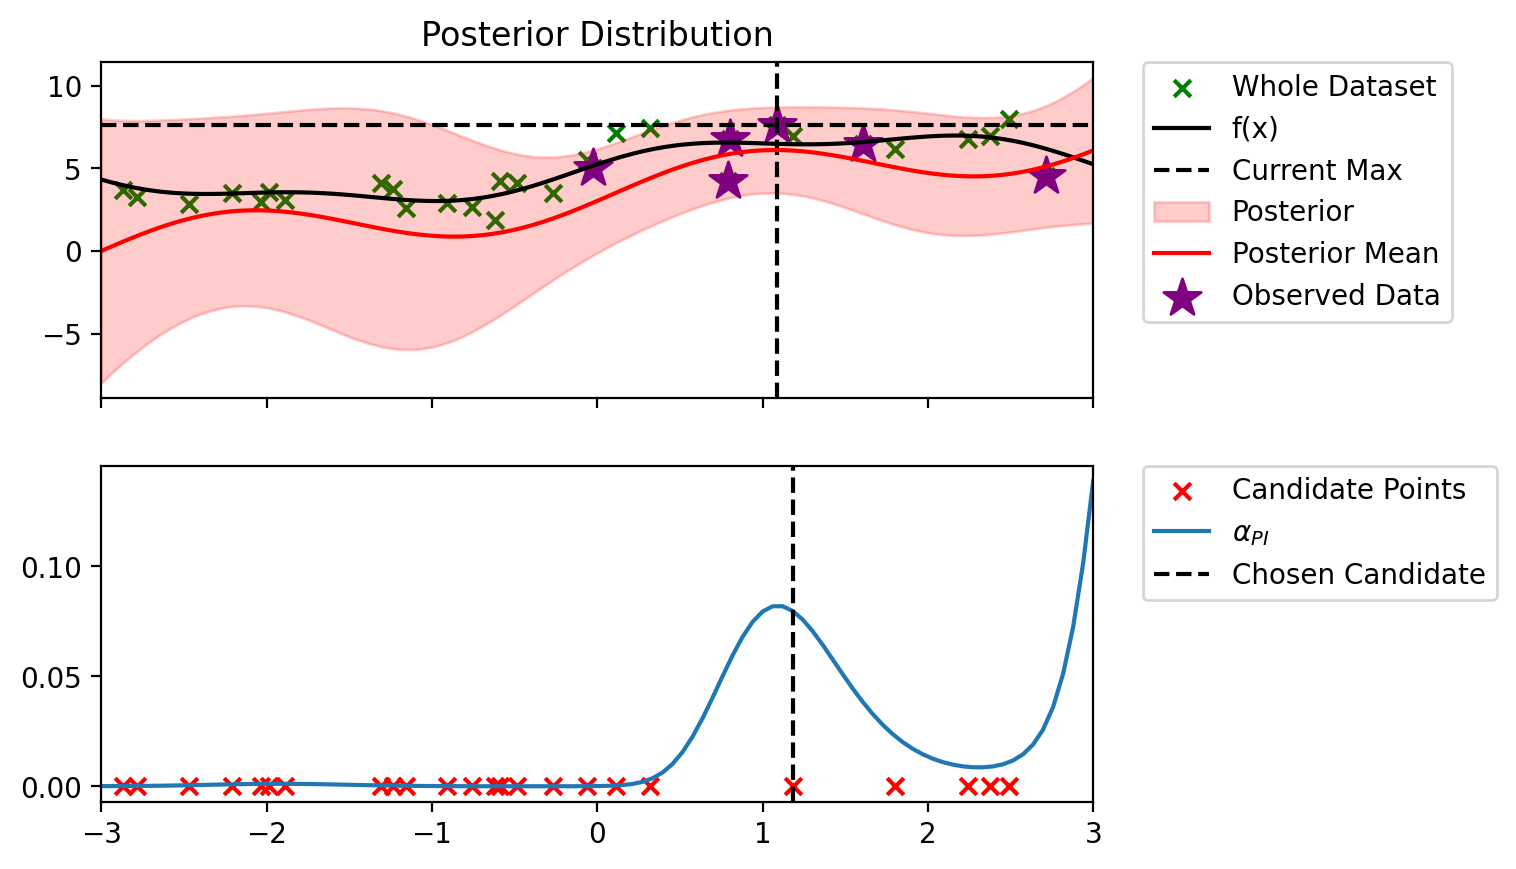

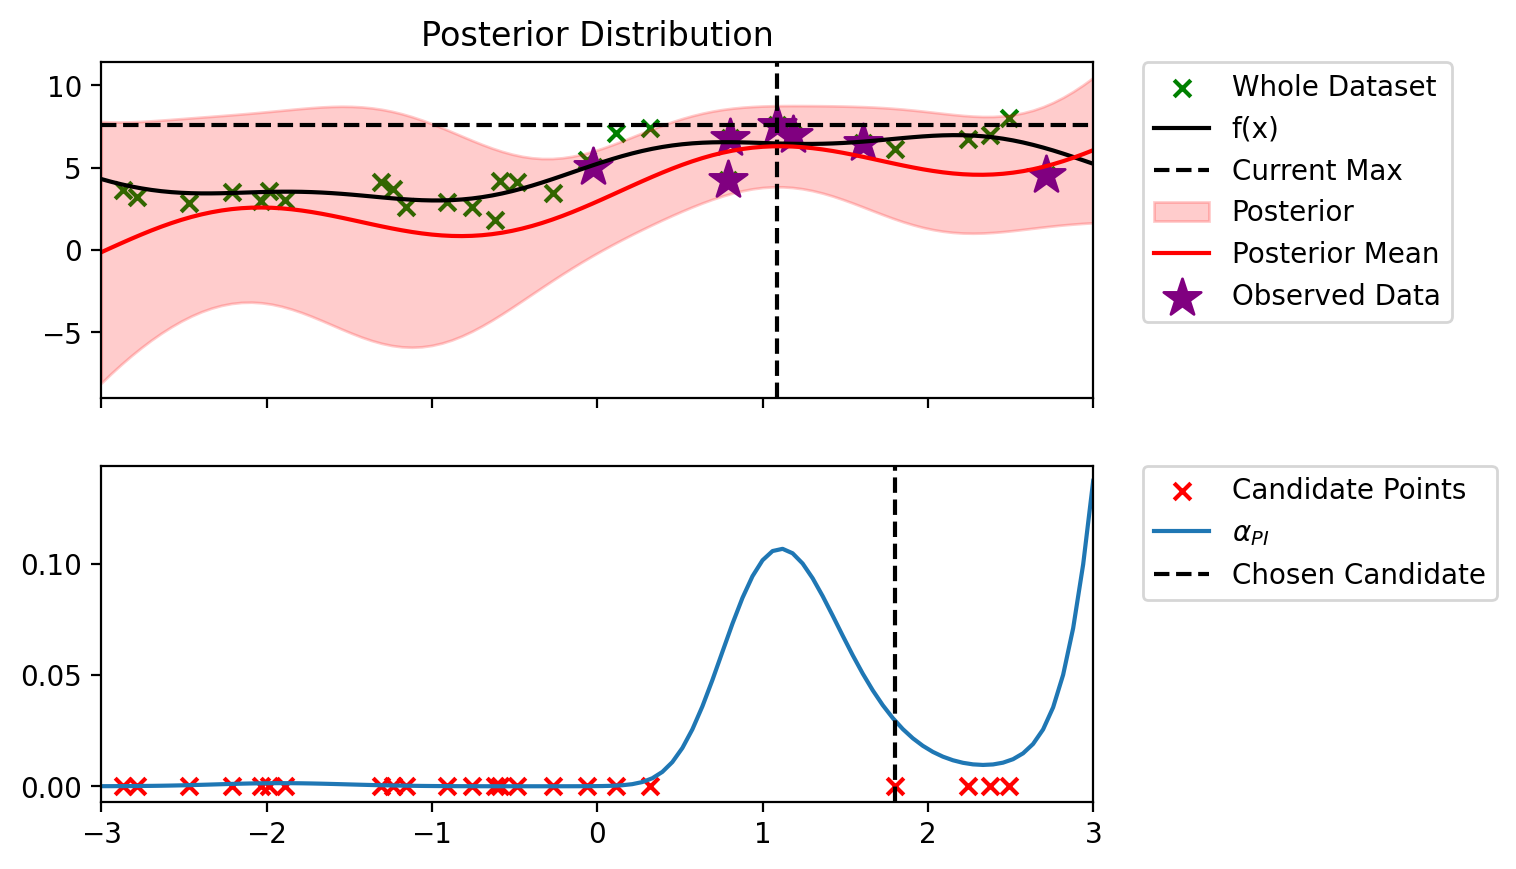

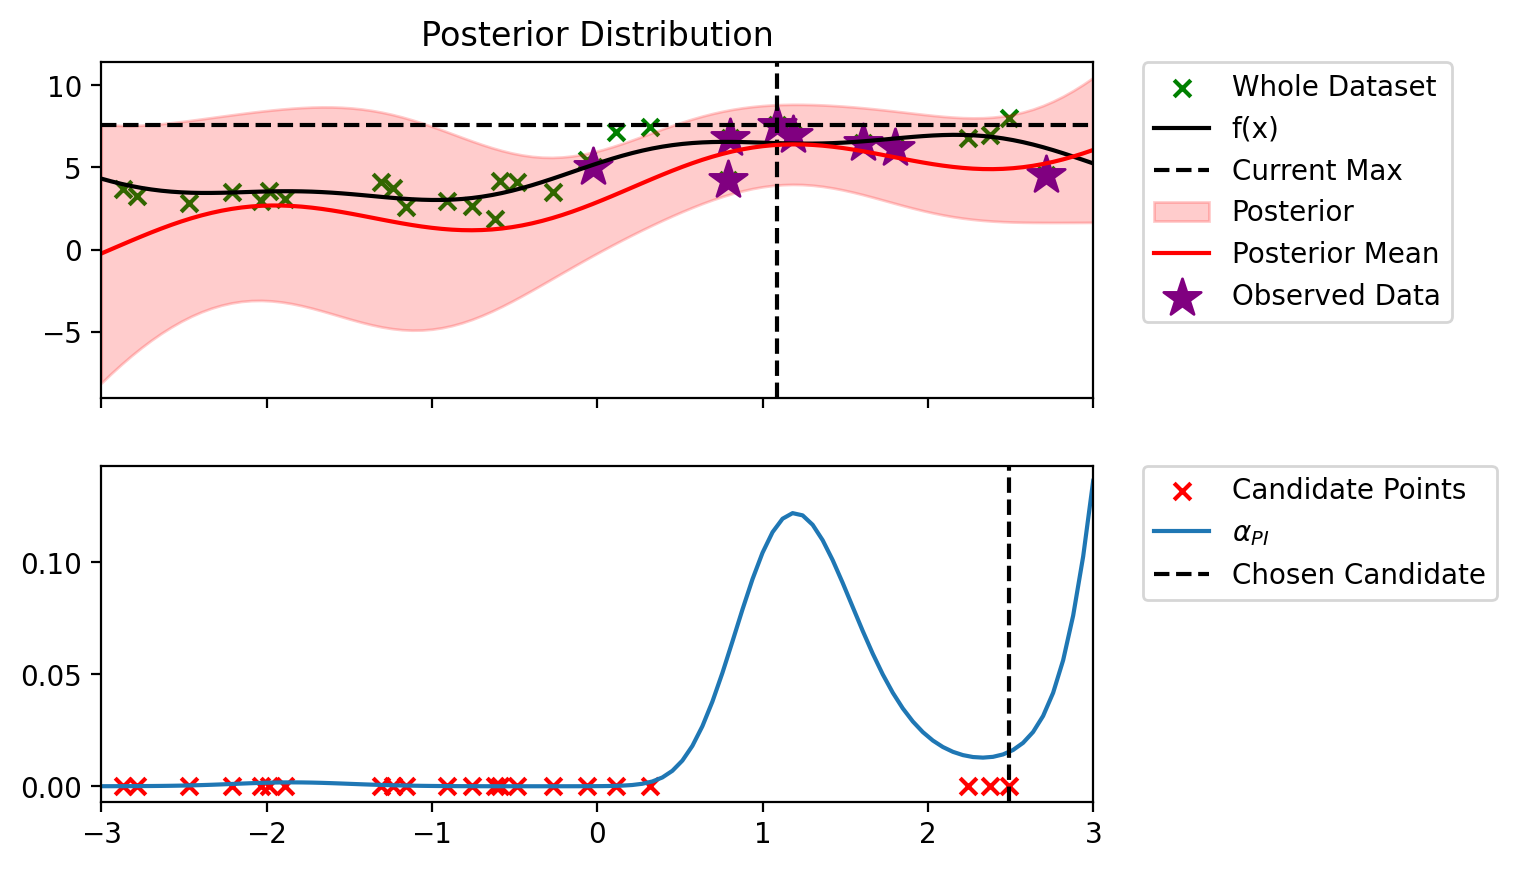

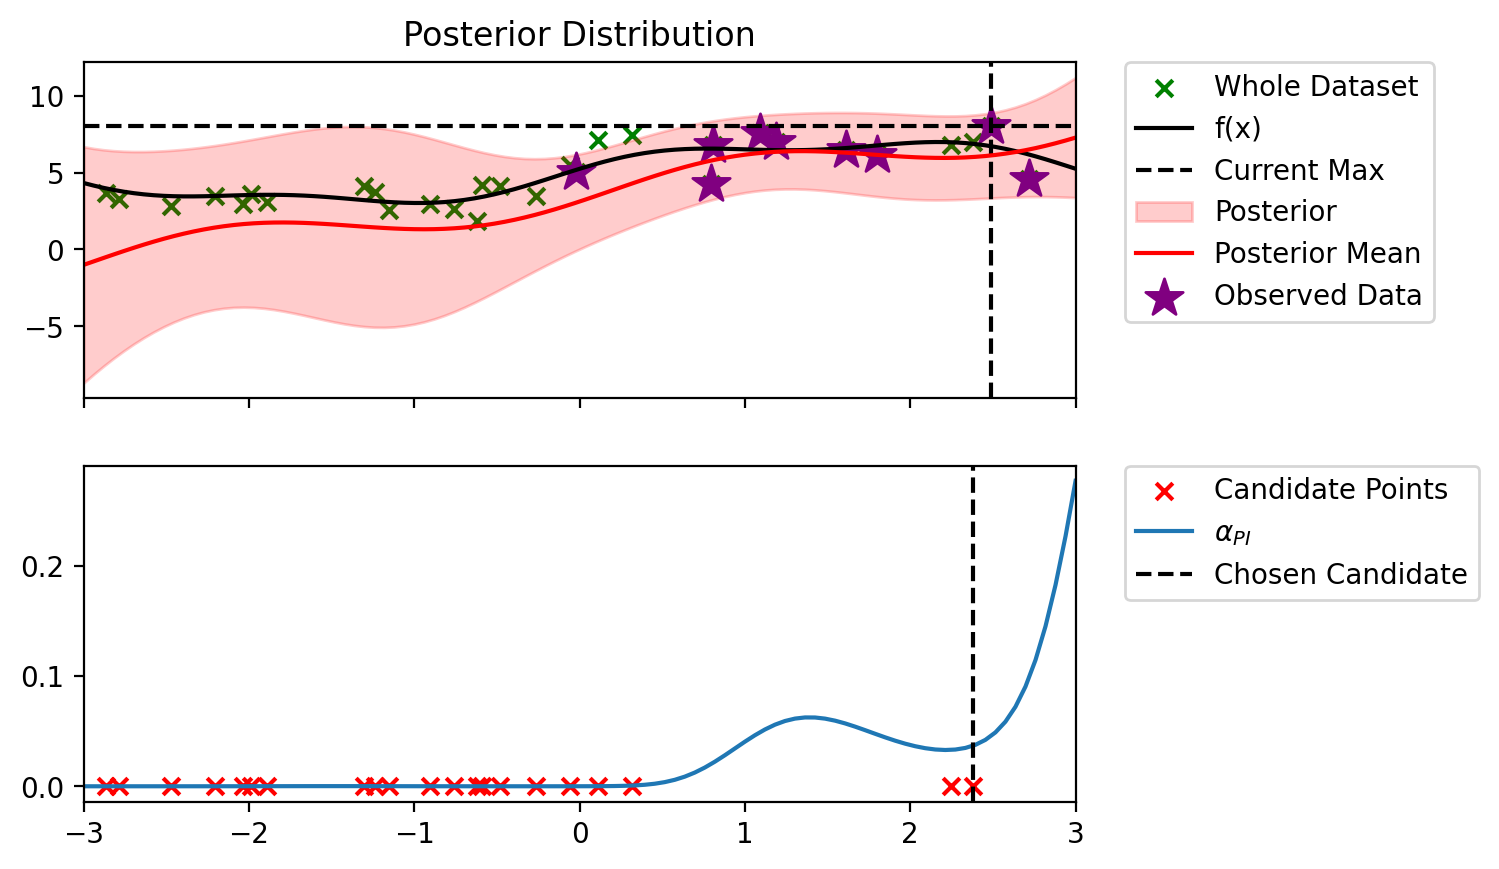

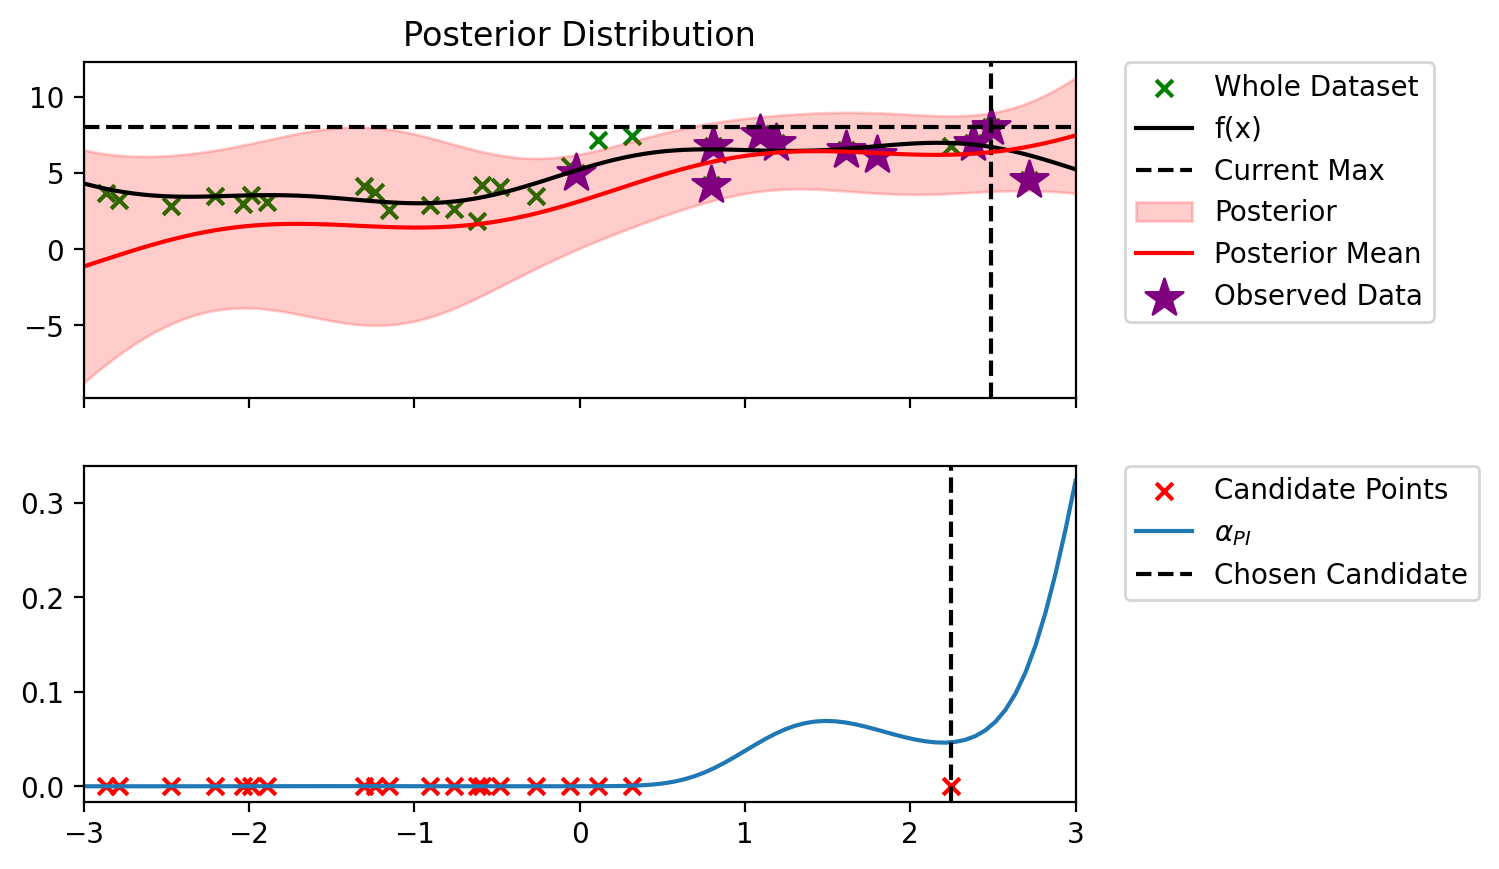

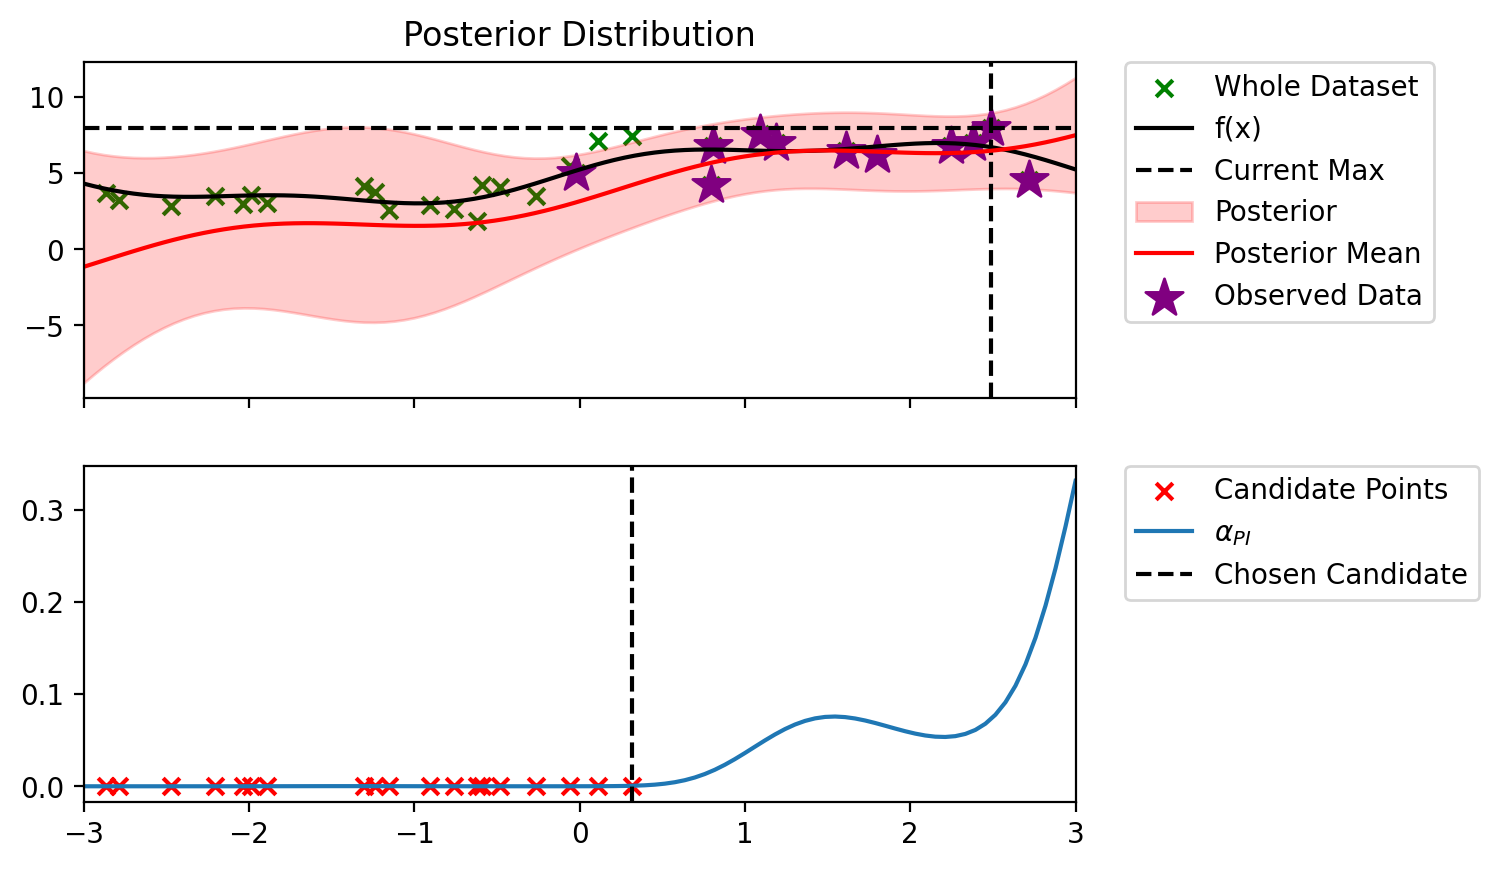

In [39]:
y_max = blr.y_total.max()
for iterations in range(10):
    candidate_points_x = setdiff1d(X_dataset, blr.X_total).reshape(-1, 1)
    candidate_points_y = setdiff1d(y_dataset, blr.y_total)
    plot_maximum_and_acq(blr, alpha_PI, candidate_points_x)
    
    alpha_candidate = alpha_PI(blr, candidate_points_x, y_max)
    
    to_add_x = candidate_points_x[alpha_candidate.argmax()].view(-1, 1)
    to_add_y = candidate_points_y[alpha_candidate.argmax()].view(-1, 1)
    
    blr.update(to_add_x, to_add_y)
    
    print(f'Iteration {iterations+1}')
    print(f"y maximum till now: {blr.y_total.max()}")